In [1]:
# Cell 1: Imports and Parameter Definitions

import MDAnalysis as mda
import numpy as np
import timeit
import os
from tqdm import tqdm
import h5py


C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Cell 2: Define File Paths and RRCS Parameters

# Define file paths
topology_file = r"C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\data\Bilis_final\ABPL1_noH.pdb"
trajectory_file = r"C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\data\Bilis_final\ABPL1_noH.xtc"

# Define selections
# Protein A: Includes residues classified as 'protein' or with residue name 'PL1' in chain A
proteinA_selection = "(protein or resname PL1 or resname AIB or resname ALY) and chainid A"

# Protein B: Includes residues classified as 'protein' in chain B
proteinB_selection = "protein and chainid B"

# Define RRCS parameters
r_min = 3.23  # Å
r_max = 4.63  # Å
cutoff = 10.0  # Å for filtering residue pairs
dt = 100.0  # ps, time interval to sample frames
bt = 0.0  # ps, start time
et = 1500000.0  # ps, end time (1500 ns)

# Define output settings
out_file = 'output_rrcs_A_vs_B'  # Output directory name
xvg_out = True  # Whether to output .xvg files for each residue pair


In [5]:
# Cell 3: Load Universe and Select Proteins

# Initialize Universe
print("Loading universe...")
u = mda.Universe(topology_file, trajectory_file)
print("Universe loaded.")

# Select Protein A and B
print("Selecting Protein A and B...")
proteinA = u.select_atoms(proteinA_selection)
proteinB = u.select_atoms(proteinB_selection)

print(f"Protein A: {len(proteinA.residues)} residues")
print(f"Protein B: {len(proteinB.residues)} residues")


Loading universe...
Universe loaded.
Selecting Protein A and B...
Protein A: 40 residues
Protein B: 396 residues


In [ ]:
# residuesA

In [6]:
# Cell 4: Map Residues to Relative Atom Indices

# List of Residues
residuesA = list(proteinA.residues)
residuesB = list(proteinB.residues)

# Create lists of residue IDs
res_idsA = [res.resid for res in residuesA]
res_idsB = [res.resid for res in residuesB]

# Create All A-B Residue Pairs without using itertools
print("Creating all A-B residue pairs without using itertools...")
res_pair = []
for a_resid in res_idsA:
    for b_resid in res_idsB:
        res_pair.append((a_resid, b_resid))
print(f"Total residue pairs (A-B): {len(res_pair)}")


Creating all A-B residue pairs without using itertools...
Total residue pairs (A-B): 15840


In [7]:
# Cell 5: Map Residues to Relative Atom Indices

# Map residues to relative atom indices for Protein A
print("Mapping residues to relative atom indices for Protein A...")
res_atomsA = {}
for res in residuesA:
    atom_indices = []
    for atom in res.atoms:
        idx = atom.index - proteinA.atoms[0].index  # Relative index
        atom_indices.append(idx)
    res_atomsA[res.resid] = atom_indices
    if not atom_indices:
        print(f"Warning: No atoms found for residue {res.resid} in Protein A.")

# Map residues to relative atom indices for Protein B
print("Mapping residues to relative atom indices for Protein B...")
res_atomsB = {}
for res in residuesB:
    atom_indices = []
    for atom in res.atoms:
        idx = atom.index - proteinB.atoms[0].index  # Relative index
        atom_indices.append(idx)
    res_atomsB[res.resid] = atom_indices
    if not atom_indices:
        print(f"Warning: No atoms found for residue {res.resid} in Protein B.")

print("Residue to atom index mapping completed.")


Mapping residues to relative atom indices for Protein A...
Mapping residues to relative atom indices for Protein B...
Residue to atom index mapping completed.


In [8]:
# Cell 6: Determine Frames to Process Based on dt

print("Determining frames to process based on dt...")
frames_to_process = []
for ts in u.trajectory:
    current_time = ts.time  # in ps
    if current_time < bt:
        continue
    if current_time > et:
        break
    # Select frames at intervals of dt
    if ((current_time - bt) % dt) < (dt / 2):
        frames_to_process.append(ts.frame)
print(f"Total frames to process: {len(frames_to_process)}")


Determining frames to process based on dt...
Total frames to process: 15001


In [9]:
# Cell 7: Initialize RRCS Data Structures

# Initialize RRCS data structure
# Using a 2D NumPy array: rows = residue pairs, columns = time points
num_pairs = len(res_pair)
num_frames = len(frames_to_process)
print(f"Initializing RRCS data structure: {num_pairs} pairs x {num_frames} frames")
rrcs_matrix = np.zeros((num_pairs, num_frames), dtype=np.float32)


Initializing RRCS data structure: 15840 pairs x 15001 frames


In [10]:
# Cell 8: Process Frames and Calculate RRCS

print("Starting trajectory analysis...")
start_time = timeit.default_timer()

# Iterate through selected frames
for frame_idx, frame in enumerate(tqdm(frames_to_process, desc="Processing frames")):
    u.trajectory[frame]
    current_time = u.trajectory.time  # in ps

    # Compute distance matrix between all atoms in Protein A and Protein B
    # Using MDAnalysis's distance_array function
    # dists shape: (nA_atoms, nB_atoms)
    dists = mda.lib.distances.distance_array(proteinA.positions, proteinB.positions, box=u.dimensions)

    # Iterate through all residue pairs and compute RRCS
    for pair_idx, (a_resid, b_resid) in enumerate(res_pair):
        # Retrieve relative atom indices
        atomsA = res_atomsA.get(a_resid, [])
        atomsB = res_atomsB.get(b_resid, [])

        if not atomsA or not atomsB:
            # No atoms in one of the residues
            rrcs = 0.0
        else:
            # Extract distances for this residue pair using relative indices
            dists_pair = dists[np.ix_(atomsA, atomsB)]
            # Compute RRCS
            # RRCS = sum over atom pairs:
            #   if distance <= r_min: score +=1
            #   elif distance >= r_max: score +=0
            #   else: score += 1 - (distance - r_min)/(r_max - r_min)
            scores = np.where(
                dists_pair <= r_min, 
                1.0, 
                np.where(
                    dists_pair >= r_max, 
                    0.0, 
                    1.0 - (dists_pair - r_min) / (r_max - r_min)
                )
            )
            total_score = np.sum(scores)
            rrcs = total_score

        # Assign RRCS to the matrix
        rrcs_matrix[pair_idx, frame_idx] = rrcs

end_time = timeit.default_timer()
elapsed_time = end_time - start_time
print(f"Trajectory analysis completed in {elapsed_time/60:.2f} minutes.")


Starting trajectory analysis...


Processing frames: 100%|██████████| 15001/15001 [1:17:35<00:00,  3.22it/s]

Trajectory analysis completed in 77.59 minutes.


In [11]:
# Cell 9: Save RRCS as .xvg Files

if xvg_out:
    print("Saving xvg files...")
    # Define function to write a single xvg file
    def write_xvg(a_resid, b_resid, times, scores, out_dir):
        xvg_filename = os.path.join(out_dir, f"{a_resid}&{b_resid}.xvg")
        with open(xvg_filename, 'w') as f:
            # Write headers
            f.write(f"# RRCS between residue {a_resid} and {b_resid}\n")
            f.write(f"@    title \"RRCS between residue {a_resid} and {b_resid}\"\n")
            f.write("@    xaxis  label \"Time (ps)\"\n")
            f.write("@    yaxis  label \"RRCS\"\n")
            f.write("@TYPE xy\n")
            # Write data
            for t, s in zip(times, scores):
                f.write(f"{t:.3f}\t{s:.3f}\n")

    # Retrieve times from the first frame
    times = [bt + i * dt for i in range(num_frames)]

    # Iterate through all residue pairs and write xvg files
    for pair_idx, (a_resid, b_resid) in enumerate(tqdm(res_pair, desc="Writing xvg files")):
        scores = rrcs_matrix[pair_idx]
        write_xvg(a_resid, b_resid, times, scores, out_file)
    print("All xvg files saved.")


Saving xvg files...


Writing xvg files: 100%|██████████| 15840/15840 [05:46<00:00, 45.68it/s]

All xvg files saved.


In [12]:
# Cell 10: Save Results to HDF5 File

print("Saving results to HDF5 file...")
h5_filename = os.path.join(out_file, "rrcs_results_rrcs.h5")
with h5py.File(h5_filename, 'w') as hf:
    # Create datasets for residue pairs and times
    hf.create_dataset('residue_pairs_A', data=np.array([pair[0] for pair in res_pair], dtype=np.int32))
    hf.create_dataset('residue_pairs_B', data=np.array([pair[1] for pair in res_pair], dtype=np.int32))

    # Create a dataset for times
    hf.create_dataset('times', data=np.array(times, dtype=np.float32))

    # Create a dataset for RRCS scores
    # Shape: (num_pairs, num_frames)
    hf.create_dataset('rrcs', data=rrcs_matrix, dtype=np.float32)
print(f"HDF5 file saved as: {h5_filename}")


Saving results to HDF5 file...
HDF5 file saved as: output_rrcs_A_vs_B\rrcs_results_rrcs.h5


In [ ]:
# Cell 11: Final Completion Message

print(f"All results saved in directory: {out_file}")


# Plot

In [ ]:
# Cell 1: Imports and Parameter Definitions

import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import MDAnalysis as mda
import os


In [ ]:
# Cell 2: Load HDF5 Data and Map Residue IDs to Names

# Define file paths
h5_filename = r"output_rrcs_A_vs_B\rrcs_results_rrcs.h5"
pdb_file = r"C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\data\Bilis_final\ABPL1_noH.pdb"

# Load HDF5 data
print("Loading HDF5 data...")
with h5py.File(h5_filename, 'r') as hf:
    residue_pairs_A = hf['residue_pairs_A'][:]
    residue_pairs_B = hf['residue_pairs_B'][:]
    times = hf['times'][:]
    rrcs = hf['rrcs'][:]  # Shape: (15048, 15001)
print("HDF5 data loaded.")

# Load PDB to map residue IDs to residue names
print("Loading PDB to map residue IDs to residue names...")
u_pdb = mda.Universe(pdb_file)
proteinA_pdb = u_pdb.select_atoms("(protein or resname PL1) and chainid A")
resid_to_resname_A = {res.resid: res.resname for res in proteinA_pdb.residues}
print("Residue ID to Residue Name mapping for Protein A completed.")


In [ ]:
# Cell 3: Compute RRCS Sums per Residue A Over Time

# Get unique residue IDs for Protein A
unique_resid_A = np.unique(residue_pairs_A)

# Initialize a dictionary to store RRCS sums per residue A
rrcs_sum_A = {resid: np.zeros_like(times, dtype=np.float32) for resid in unique_resid_A}

print("Computing RRCS sums for each residue A over time...")

# Iterate over residue pairs and accumulate RRCS sums
for i in tqdm(range(len(residue_pairs_A)), desc="Accumulating RRCS sums"):
    a_resid = residue_pairs_A[i]
    rrcs_sum_A[a_resid] += rrcs[i]

print("RRCS sums computation completed.")


In [ ]:
# Cell 4: Plotting RRCS Sums Over Time (Direct Plot)

import matplotlib.pyplot as plt

print("Plotting RRCS sums over time for each residue A...")

plt.figure(figsize=(15, 10))

for resid, rrcs_sum in rrcs_sum_A.items():
    resname = resid_to_resname_A.get(resid, f"Res{resid}")
    plt.plot(times, rrcs_sum, label=f"{resname} ({resid})", alpha=0.5)

plt.xlabel("Time (ps)")
plt.ylabel("RRCS Sum")
plt.title("RRCS Sum Over Time for Each Residue A")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()


In [ ]:
# Cell 5-1: Plotting RRCS Sums Over Time (Smoothed Plot)

import matplotlib.pyplot as plt

# Define moving average window size
window_size = 10  # Can be modified as per user preference

def moving_average(data, window_size):
    """Compute the moving average using a window of specified size."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

print(f"Plotting smoothed RRCS sums over time with window size {window_size}...")

plt.figure(figsize=(15, 10))

for resid, rrcs_sum in rrcs_sum_A.items():
    resname = resid_to_resname_A.get(resid, f"Res{resid}")
    smoothed_rrcs = moving_average(rrcs_sum, window_size)
    plt.plot(times, smoothed_rrcs, label=f"{resname} ({resid})", alpha=0.5)

plt.xlabel("Time (ps)")
plt.ylabel("Smoothed RRCS Sum")
plt.title(f"Smoothed RRCS Sum Over Time for Each Residue A (Window Size = {window_size})")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()


In [ ]:
# Cell 5-2: Plotting RRCS Sums Over Time (Smoothed Plot)

import matplotlib.pyplot as plt

# Define moving average window size
window_size = 50  # Can be modified as per user preference

def moving_average(data, window_size):
    """Compute the moving average using a window of specified size."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

print(f"Plotting smoothed RRCS sums over time with window size {window_size}...")

plt.figure(figsize=(15, 10))

for resid, rrcs_sum in rrcs_sum_A.items():
    resname = resid_to_resname_A.get(resid, f"Res{resid}")
    smoothed_rrcs = moving_average(rrcs_sum, window_size)
    plt.plot(times, smoothed_rrcs, label=f"{resname} ({resid})", alpha=0.5)

plt.xlabel("Time (ps)")
plt.ylabel("Smoothed RRCS Sum")
plt.title(f"Smoothed RRCS Sum Over Time for Each Residue A (Window Size = {window_size})")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()


In [ ]:
# Cell 5-3: Plotting RRCS Sums Over Time (Smoothed Plot)

import matplotlib.pyplot as plt

# Define moving average window size
window_size = 100  # Can be modified as per user preference

def moving_average(data, window_size):
    """Compute the moving average using a window of specified size."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

print(f"Plotting smoothed RRCS sums over time with window size {window_size}...")

plt.figure(figsize=(15, 10))

for resid, rrcs_sum in rrcs_sum_A.items():
    resname = resid_to_resname_A.get(resid, f"Res{resid}")
    smoothed_rrcs = moving_average(rrcs_sum, window_size)
    plt.plot(times, smoothed_rrcs, label=f"{resname} ({resid})", alpha=0.5)

plt.xlabel("Time (ps)")
plt.ylabel("Smoothed RRCS Sum")
plt.title(f"Smoothed RRCS Sum Over Time for Each Residue A (Window Size = {window_size})")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()


In [ ]:
# Cell 6: Plotting Average RRCS Sum per Residue A

import matplotlib.pyplot as plt

print("Calculating average RRCS sums for each residue A...")

# Calculate mean RRCS sum over all time points for each residue A
average_rrcs_A = {resid: np.mean(rrcs_sum) for resid, rrcs_sum in rrcs_sum_A.items()}

# Prepare data for plotting
residues_sorted = sorted(average_rrcs_A.keys())
resnames_sorted = [resid_to_resname_A.get(resid, f"Res{resid}") for resid in residues_sorted]
avg_rrcs_values = [average_rrcs_A[resid] for resid in residues_sorted]

print("Plotting average RRCS sums...")

plt.figure(figsize=(15, 6))
plt.bar(resnames_sorted, avg_rrcs_values, color='skyblue')
plt.xlabel("Residue A Sequence")
plt.ylabel("Average RRCS Sum")
plt.title("Average RRCS Sum Over Time for Each Residue A")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Loading HDF5 data...
HDF5 data loaded.
Mapping residue IDs to residue names for Protein A...
Residue ID to Residue Name mapping for Protein A completed.
Computing RRCS sums for each residue A over time...


Accumulating RRCS sums: 100%|██████████| 15840/15840 [00:00<00:00, 110097.67it/s]


RRCS sums computation completed.
Preparing data for concatenated plot...
Plotting Direct RRCS Sum Over Time for Each Residue A...


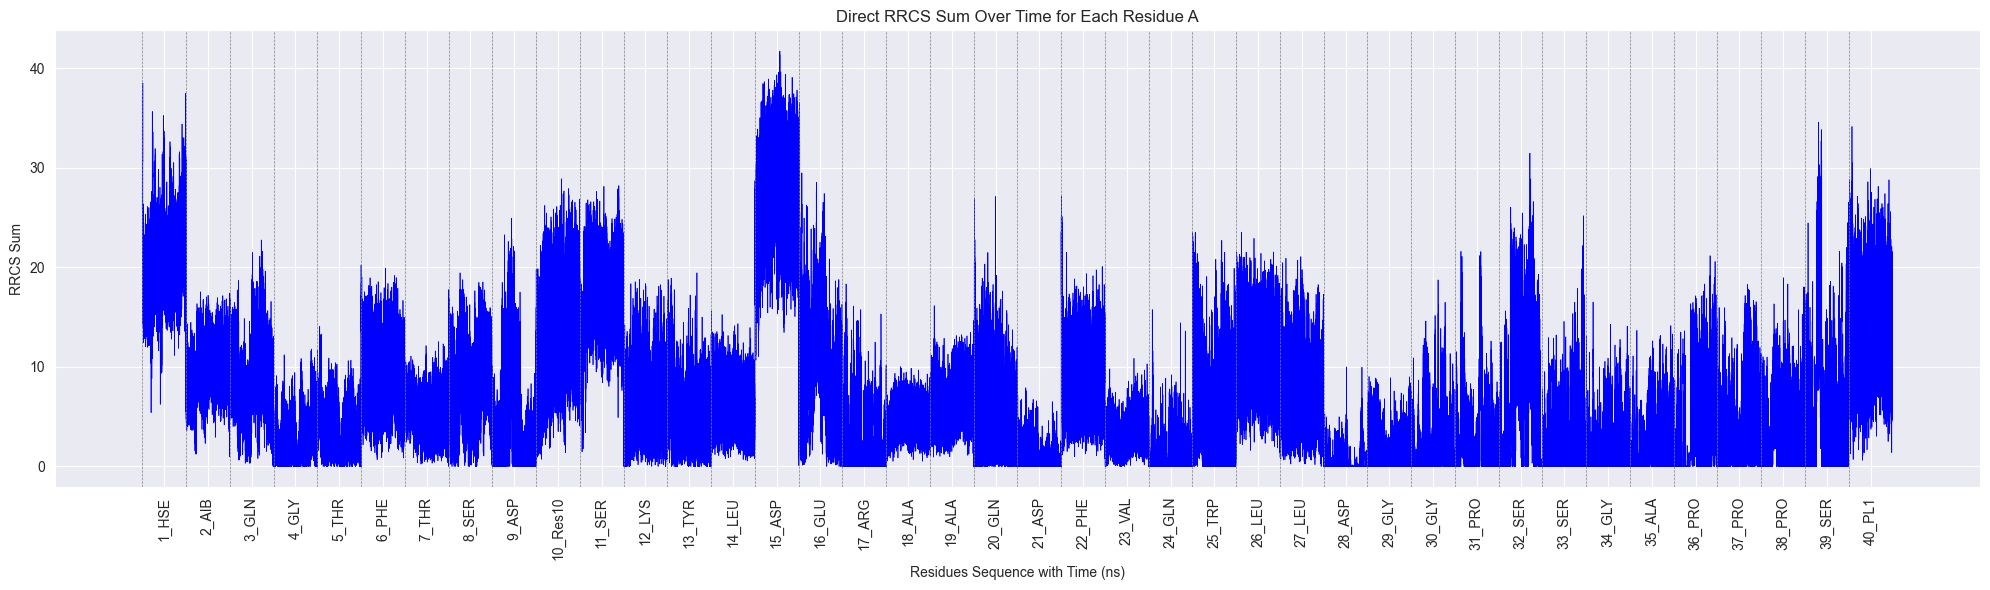

Plotting Smoothed RRCS Sum Over Time for Each Residue A with Window Size = 1000...


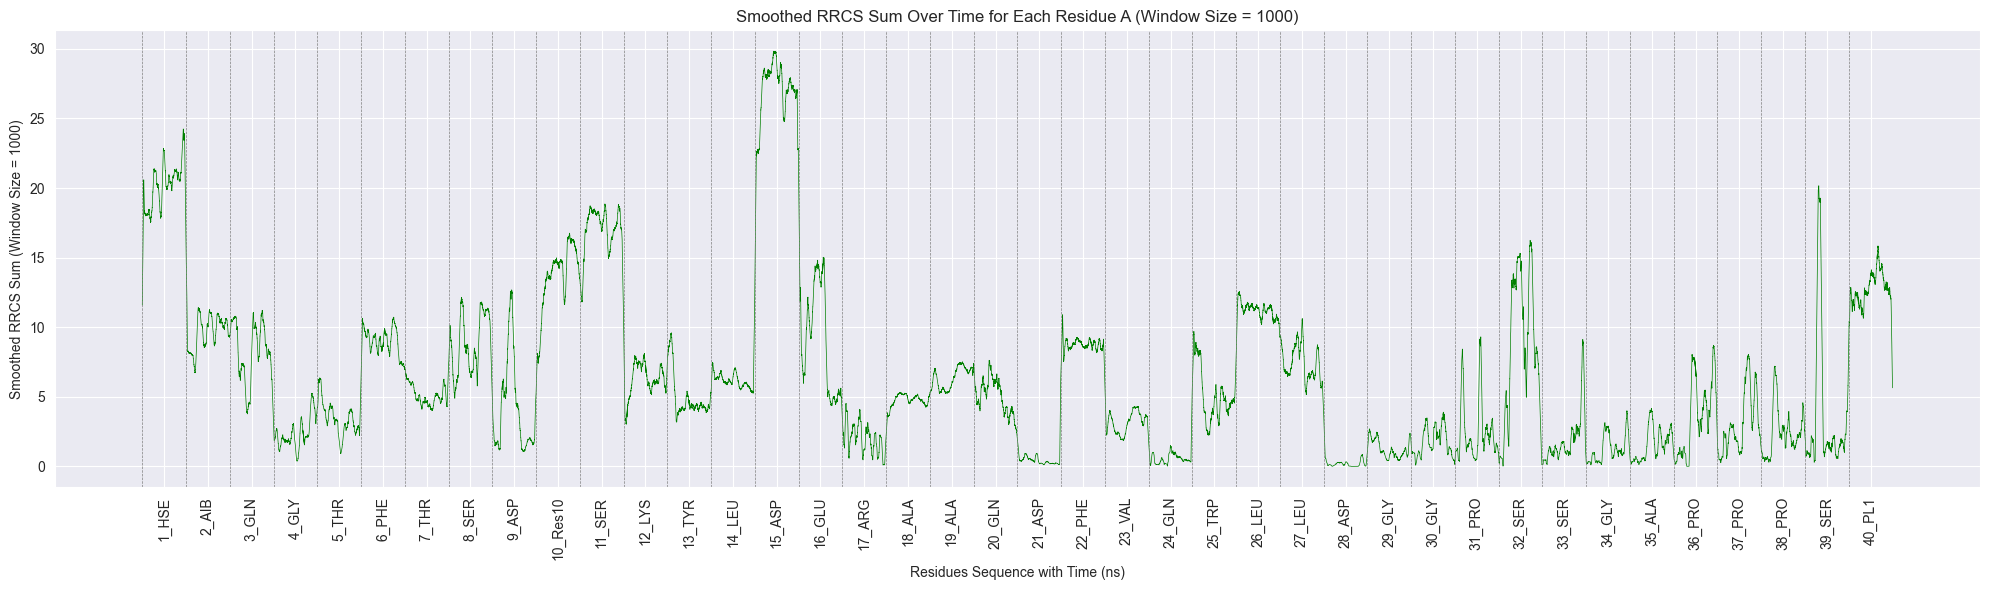

Calculating average RRCS sums for each residue A...
Plotting Average RRCS Sum Over Time for Each Residue A...


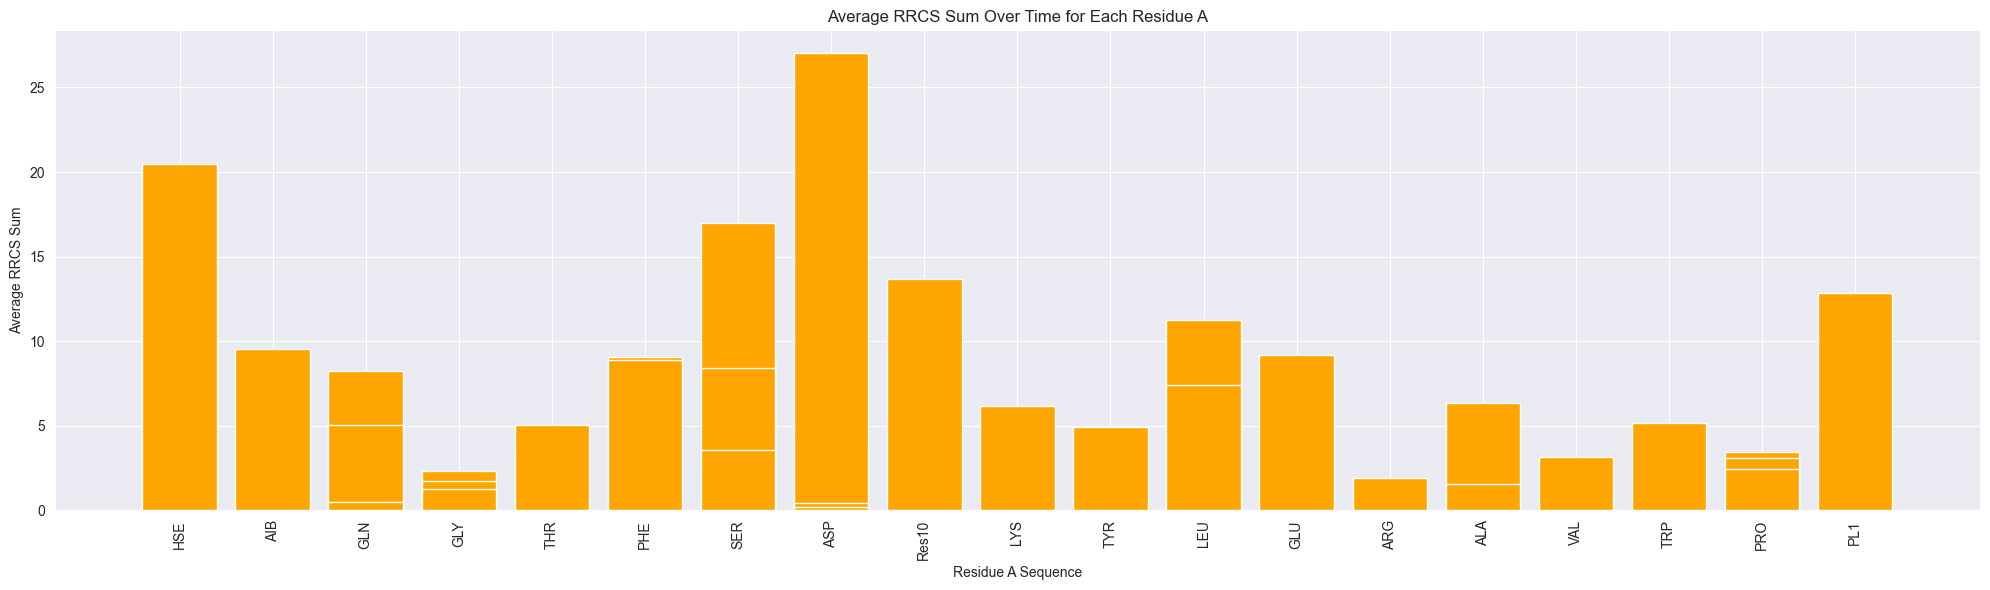

All plots have been generated and saved in the directory: output_rrcs_A_vs_B


In [15]:
# Cell 11: Plotting RRCS Sums with Concatenated Residues

import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import MDAnalysis as mda

# =======================
# Define File Paths
# =======================
h5_filename = r"output_rrcs_A_vs_B\rrcs_results_rrcs.h5"  # Adjust if necessary
pdb_file = r"C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\data\Bilis_final\ABPL1_noH.pdb"

# =======================
# Load HDF5 Data
# =======================
print("Loading HDF5 data...")
with h5py.File(h5_filename, 'r') as hf:
    residue_pairs_A = hf['residue_pairs_A'][:]  # Array of Protein A residue IDs
    residue_pairs_B = hf['residue_pairs_B'][:]  # Array of Protein B residue IDs
    times = hf['times'][:]                    # Array of time points (ps)
    rrcs = hf['rrcs'][:]                      # 2D array: (num_pairs, num_frames)
print("HDF5 data loaded.")

# =======================
# Map Residue IDs to Residue Names
# =======================
print("Mapping residue IDs to residue names for Protein A...")
u_pdb = mda.Universe(pdb_file)
proteinA_pdb = u_pdb.select_atoms("(protein or resname PL1 or resname AIB) and chainid A")
resid_to_resname_A = {res.resid: res.resname for res in proteinA_pdb.residues}
print("Residue ID to Residue Name mapping for Protein A completed.")

# =======================
# Compute RRCS Sums per Residue A Over Time
# =======================
unique_resid_A = np.unique(residue_pairs_A)
rrcs_sum_A = {resid: np.zeros_like(times, dtype=np.float32) for resid in unique_resid_A}

print("Computing RRCS sums for each residue A over time...")
for i in tqdm(range(len(residue_pairs_A)), desc="Accumulating RRCS sums"):
    a_resid = residue_pairs_A[i]
    rrcs_sum_A[a_resid] += rrcs[i]
print("RRCS sums computation completed.")

# =======================
# Define Moving Average Function
# =======================
def moving_average(data, window_size):
    """Compute the moving average using a window of specified size."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

# =======================
# Prepare Data for Concatenated Plot
# =======================
print("Preparing data for concatenated plot...")
num_residues = len(rrcs_sum_A)
num_frames = len(times)
simulation_duration = et - bt  # 1500ns as defined earlier

# Initialize lists to hold concatenated RRCS and cumulative times
concatenated_rrcs = []
concatenated_times = []
residue_boundaries = []
residue_labels = []
current_time = 0.0

# Sort residues for consistent ordering
sorted_resid_A = sorted(rrcs_sum_A.keys())

for resid in sorted_resid_A:
    rrcs_sum = rrcs_sum_A[resid]
    concatenated_rrcs.extend(rrcs_sum)
    concatenated_times.extend(current_time + times)
    residue_boundaries.append(current_time)
    resname = resid_to_resname_A.get(resid, f"Res{resid}")
    label = f"{resid}_{resname}"
    residue_labels.append(label)
    current_time += simulation_duration  # Increment by 1500ns per residue

concatenated_rrcs = np.array(concatenated_rrcs)
concatenated_times = np.array(concatenated_times)

# =======================
# Plot 1: Direct Plot
# =======================
print("Plotting Direct RRCS Sum Over Time for Each Residue A...")
plt.figure(figsize=(20, 6))
plt.plot(concatenated_times, concatenated_rrcs, color='blue', linewidth=0.5)
plt.xlabel("Residues Sequence with Time (ns)")
plt.ylabel("RRCS Sum")
plt.title("Direct RRCS Sum Over Time for Each Residue A")

# Add vertical dashed lines to indicate residue boundaries
for boundary in residue_boundaries:
    plt.axvline(x=boundary, color='grey', linestyle='--', linewidth=0.5)

# Set x-ticks at the middle of each residue's time segment
x_ticks = [boundary + (simulation_duration / 2) for boundary in residue_boundaries]
plt.xticks(x_ticks, residue_labels, rotation=90)

plt.tight_layout()
plt.show()

# =======================
# Plot 2: Smoothed Plot with Moving Average
# =======================
window_size = 1000  # User can change this value

print(f"Plotting Smoothed RRCS Sum Over Time for Each Residue A with Window Size = {window_size}...")
smoothed_rrcs = moving_average(concatenated_rrcs, window_size)

plt.figure(figsize=(20, 6))
plt.plot(concatenated_times, smoothed_rrcs, color='green', linewidth=0.5)
plt.xlabel("Residues Sequence with Time (ns)")
plt.ylabel(f"Smoothed RRCS Sum (Window Size = {window_size})")
plt.title(f"Smoothed RRCS Sum Over Time for Each Residue A (Window Size = {window_size})")

# Add vertical dashed lines to indicate residue boundaries
for boundary in residue_boundaries:
    plt.axvline(x=boundary, color='grey', linestyle='--', linewidth=0.5)

# Set x-ticks at the middle of each residue's time segment
plt.xticks(x_ticks, residue_labels, rotation=90)

plt.tight_layout()
plt.show()

# =======================
# Plot 3: Average RRCS Sum per Residue A
# =======================
print("Calculating average RRCS sums for each residue A...")
average_rrcs_A = {resid: np.mean(rrcs_sum) for resid, rrcs_sum in rrcs_sum_A.items()}

# Prepare data for plotting
residues_sorted = sorted(average_rrcs_A.keys())
resnames_sorted = [resid_to_resname_A.get(resid, f"Res{resid}") for resid in residues_sorted]
avg_rrcs_values = [average_rrcs_A[resid] for resid in residues_sorted]

print("Plotting Average RRCS Sum Over Time for Each Residue A...")
plt.figure(figsize=(20, 6))
plt.bar(resnames_sorted, avg_rrcs_values, color='orange')
plt.xlabel("Residue A Sequence")
plt.ylabel("Average RRCS Sum")
plt.title("Average RRCS Sum Over Time for Each Residue A")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print(f"All plots have been generated and saved in the directory: {out_file}")


Loading HDF5 data...
HDF5 data loaded.
Mapping residue IDs to residue names for Protein A and B...
Residue ID to Residue Name mapping completed.
Defining amino acid properties for Protein B...
Amino acid properties mapping completed.
Computing RRCS sums for each residue A categorized by residue B's properties...


Accumulating RRCS sums by property: 100%|██████████| 15840/15840 [00:00<00:00, 164849.82it/s]

RRCS sums computation by property completed.
Preparing data for concatenated plots...


Plotting Smoothed Density Map...


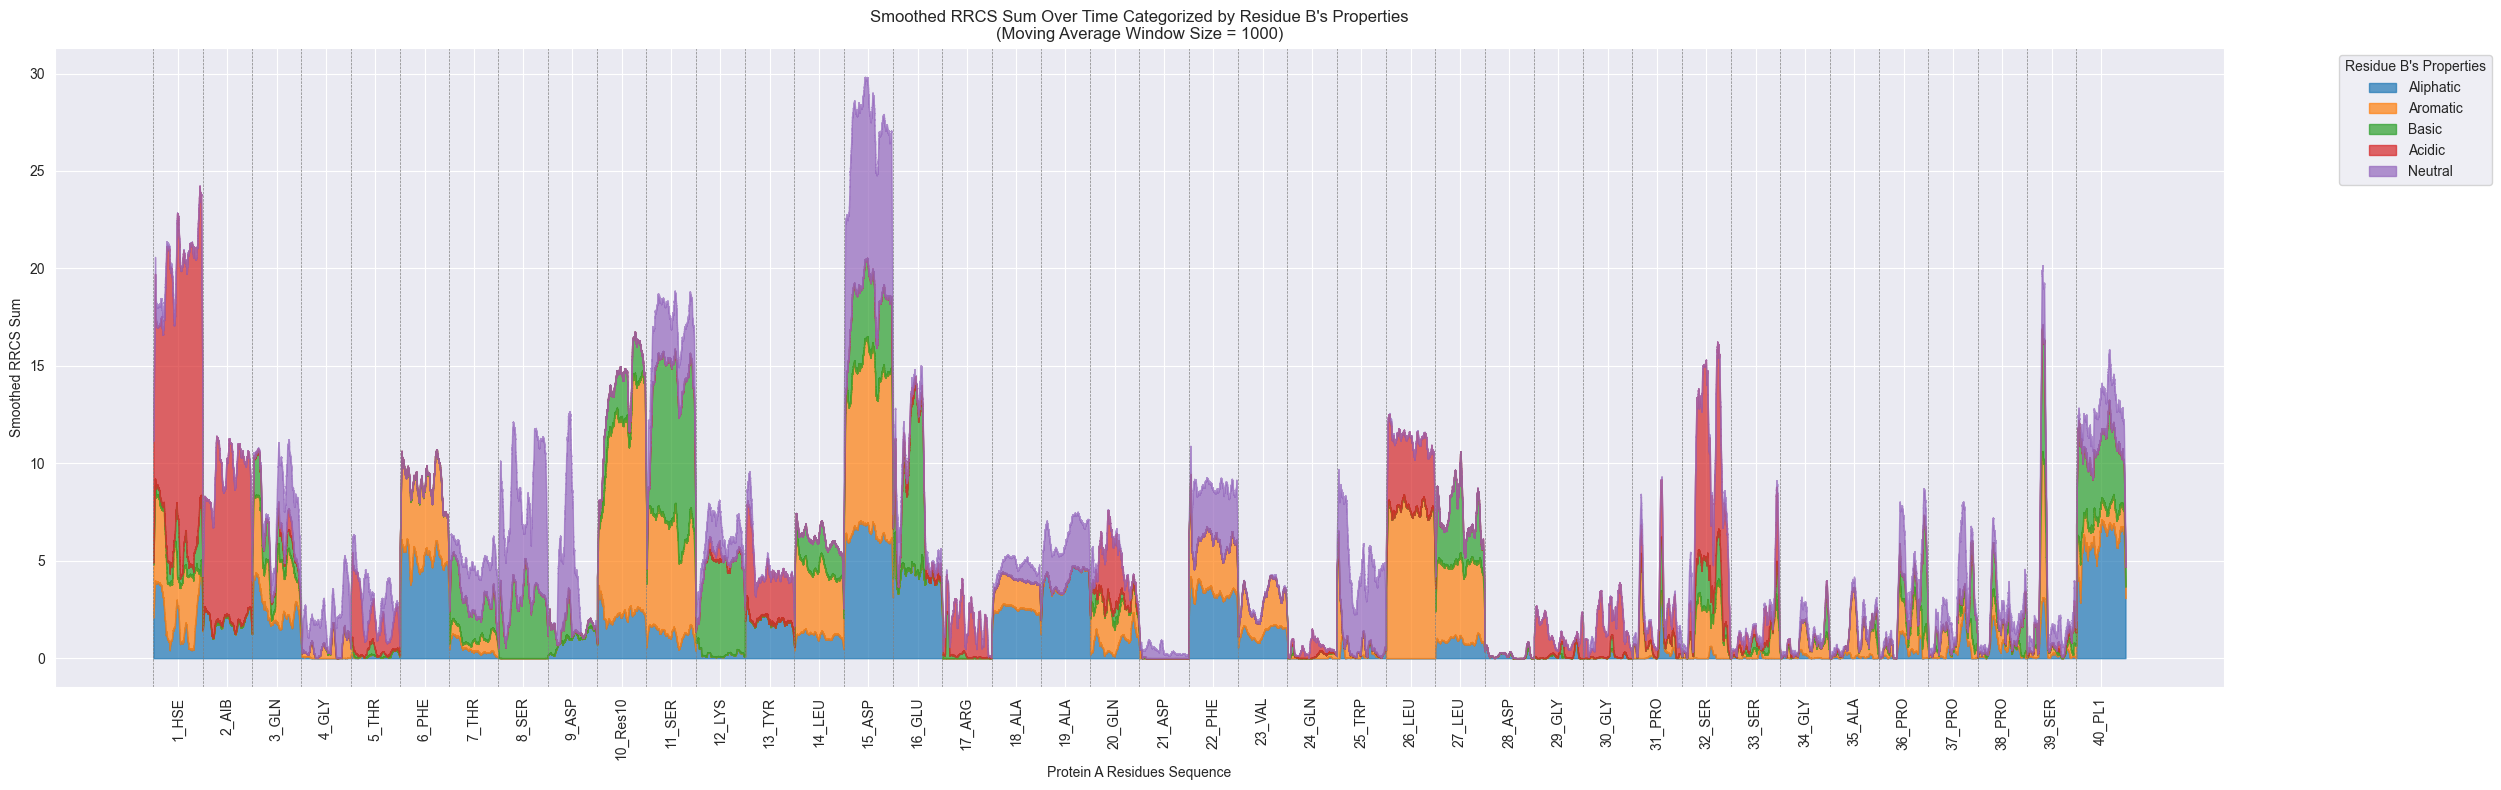

Plotting Average Density Map...


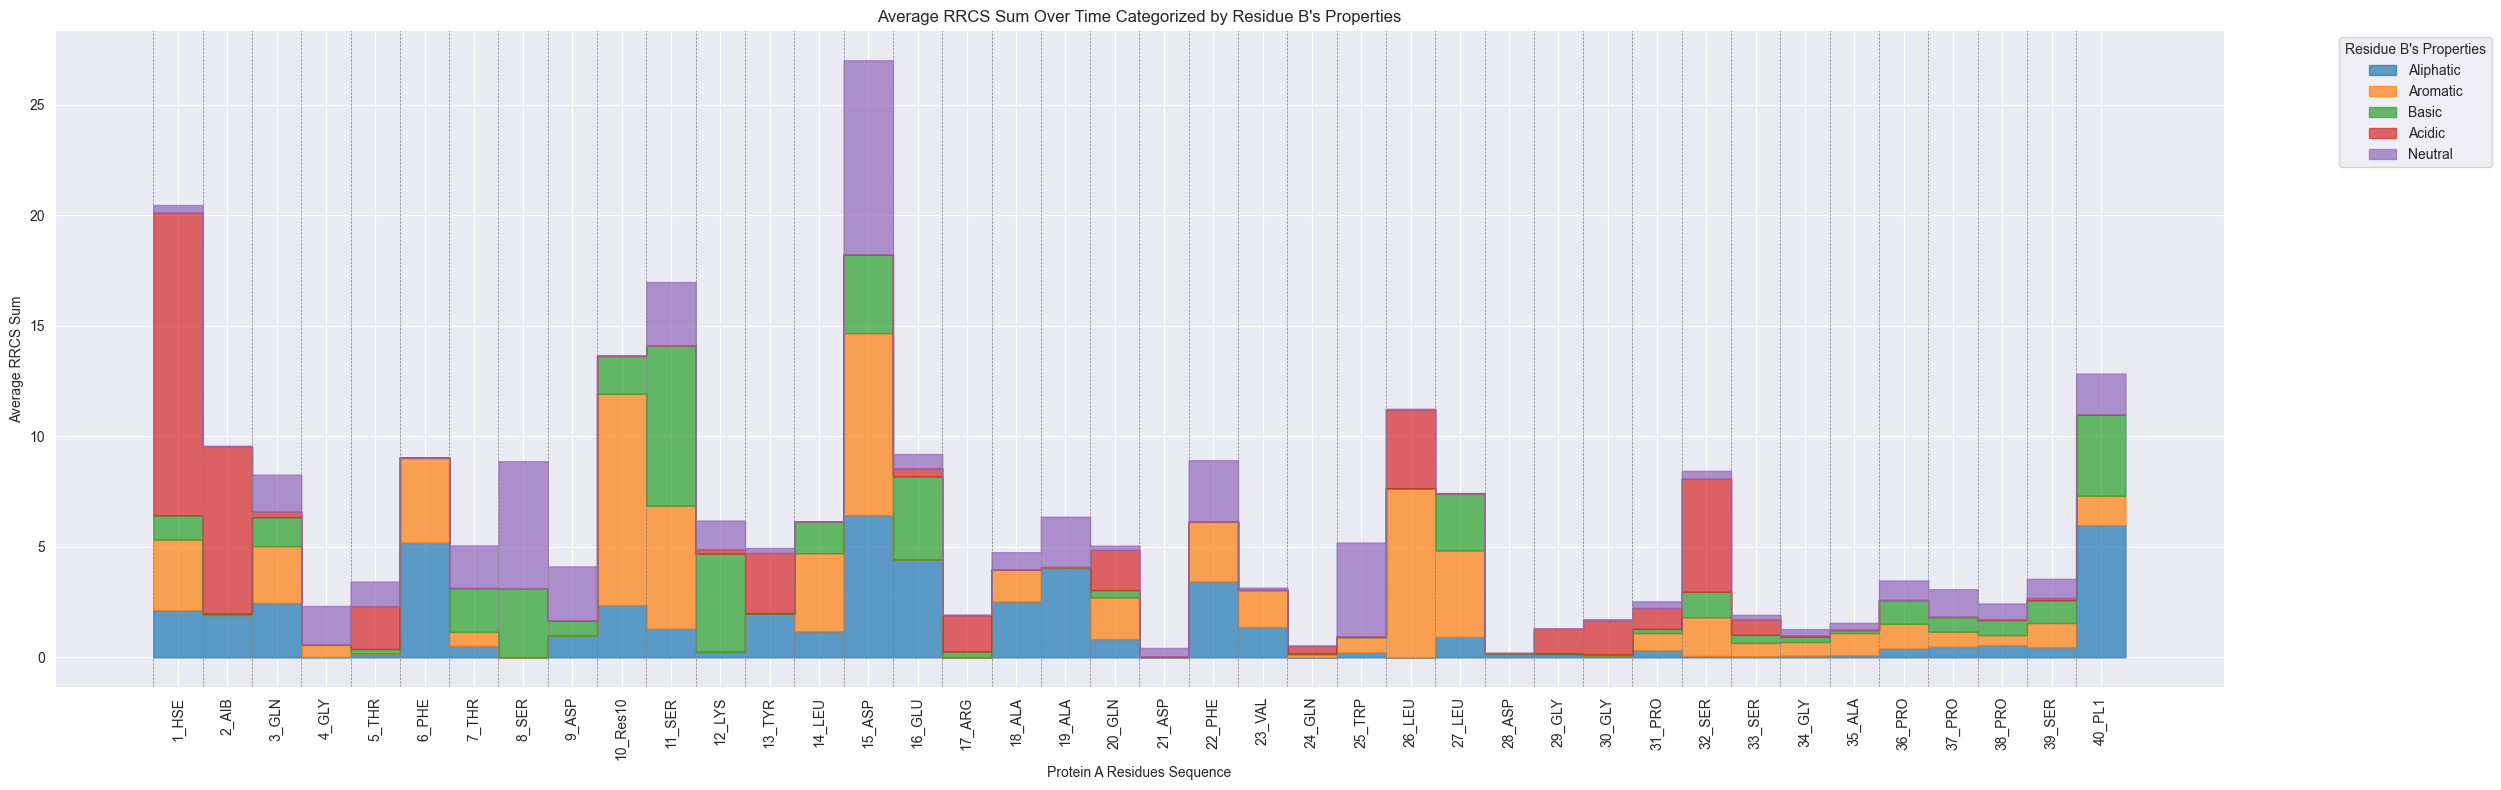

All density plots have been generated and saved in the directory: output_rrcs_A_vs_B


In [14]:
# Cell 12: Plotting Smoothed and Average Density Maps

import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import MDAnalysis as mda

# =======================
# Define File Paths
# =======================
h5_filename = r"output_rrcs_A_vs_B\rrcs_results_rrcs.h5"  # Adjust if necessary
pdb_file = r"C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\data\Bilis_final\ABPL1_noH.pdb"

# =======================
# Load HDF5 Data
# =======================
print("Loading HDF5 data...")
with h5py.File(h5_filename, 'r') as hf:
    residue_pairs_A = hf['residue_pairs_A'][:]  # Array of Protein A residue IDs
    residue_pairs_B = hf['residue_pairs_B'][:]  # Array of Protein B residue IDs
    times = hf['times'][:]                    # Array of time points (ps)
    rrcs = hf['rrcs'][:]                      # 2D array: (num_pairs, num_frames)
print("HDF5 data loaded.")

# =======================
# Map Residue IDs to Residue Names for Protein A and B
# =======================
print("Mapping residue IDs to residue names for Protein A and B...")
u_pdb = mda.Universe(pdb_file)
proteinA_pdb = u_pdb.select_atoms("(protein or resname PL1 or resname AIB) and chainid A")
proteinB_pdb = u_pdb.select_atoms("protein and chainid B")  # Adjust if necessary

resid_to_resname_A = {res.resid: res.resname for res in proteinA_pdb.residues}
resid_to_resname_B = {res.resid: res.resname for res in proteinB_pdb.residues}
print("Residue ID to Residue Name mapping completed.")

# =======================
# Define Residue B's Amino Acid Properties
# =======================
print("Defining amino acid properties for Protein B...")
amino_acid_properties = {
    'ALA': 'Aliphatic', 'VAL': 'Aliphatic', 'LEU': 'Aliphatic', 'ILE': 'Aliphatic',
    'PRO': 'Aliphatic', 'MET': 'Aliphatic',
    'PHE': 'Aromatic', 'TYR': 'Aromatic', 'TRP': 'Aromatic',
    'HIS': 'Basic', 'LYS': 'Basic', 'ARG': 'Basic',
    'ASP': 'Acidic', 'GLU': 'Acidic',
    'ASN': 'Neutral', 'GLN': 'Neutral', 'SER': 'Neutral', 'THR': 'Neutral',
    'CYS': 'Neutral', 'GLY': 'Neutral', 'SEC': 'Neutral', 'UNK': 'Neutral'
}

# Function to get property
def get_amino_acid_property(resname):
    return amino_acid_properties.get(resname.upper(), 'Neutral')

# Map residue B's resid to property
resid_to_property_B = {}
for resid, resname in resid_to_resname_B.items():
    prop = get_amino_acid_property(resname)
    resid_to_property_B[resid] = prop
print("Amino acid properties mapping completed.")

# =======================
# Compute RRCS Sums per Residue A and per Property Over Time
# =======================
print("Computing RRCS sums for each residue A categorized by residue B's properties...")
unique_resid_A = np.unique(residue_pairs_A)
properties = ['Aliphatic', 'Aromatic', 'Basic', 'Acidic', 'Neutral']

# Initialize a dictionary to store RRCS sums per residue A and per property
rrcs_sum_A_properties = {resid: {prop: np.zeros_like(times, dtype=np.float32) for prop in properties} for resid in unique_resid_A}

# Iterate through residue pairs and accumulate RRCS sums based on residue B's property
for i in tqdm(range(len(residue_pairs_A)), desc="Accumulating RRCS sums by property"):
    a_resid = residue_pairs_A[i]
    b_resid = residue_pairs_B[i]
    property_B = resid_to_property_B.get(b_resid, 'Neutral')  # Default to Neutral if not found
    rrcs_value = rrcs[i]
    rrcs_sum_A_properties[a_resid][property_B] += rrcs_value
print("RRCS sums computation by property completed.")

# =======================
# Prepare Data for Concatenated Plot
# =======================
print("Preparing data for concatenated plots...")
num_residues = len(unique_resid_A)
simulation_duration = 1500  # ns, as per total simulation length
time_per_residue = simulation_duration  # Each residue spans 1500ns

# Initialize lists to hold concatenated RRCS and cumulative times for smoothed and average plots
concatenated_rrcs_smoothed = {prop: [] for prop in properties}
concatenated_rrcs_average = {prop: [] for prop in properties}
concatenated_labels = []
current_time = 0.0

# Define moving average window size (modifiable by user)
window_size = 1000  # You can change this value as needed

# Sort residues for consistent ordering
sorted_resid_A = sorted(rrcs_sum_A_properties.keys())

for resid in sorted_resid_A:
    resname = resid_to_resname_A.get(resid, f"Res{resid}")
    label = f"{resid}_{resname}"
    concatenated_labels.append(label)
    
    for prop in properties:
        # Smoothed RRCS using moving average
        smoothed_rrcs = np.convolve(rrcs_sum_A_properties[resid][prop], 
                                    np.ones(window_size)/window_size, 
                                    mode='same')
        concatenated_rrcs_smoothed[prop].extend(smoothed_rrcs)
        
        # Average RRCS (constant value across the residue's simulation period)
        average_rrcs = np.mean(rrcs_sum_A_properties[resid][prop])
        concatenated_rrcs_average[prop].extend([average_rrcs] * len(times))
    
    current_time += simulation_duration  # Increment by 1500ns per residue

# Create a single x-axis array spanning all residues
total_time = simulation_duration * num_residues  # Total time in ns
x = np.linspace(0, total_time, num_residues * len(times))

# Create property-wise 2D arrays for plotting
# Shape: (num_properties, num_residues * num_frames)
density_data_smoothed = np.array([concatenated_rrcs_smoothed[prop] for prop in properties])
density_data_average = np.array([concatenated_rrcs_average[prop] for prop in properties])

# =======================
# Plot 1: Smoothed Density Map
# =======================
print("Plotting Smoothed Density Map...")
    
# Define color map for properties
property_colors = {
    'Aliphatic': '#1f77b4',  # Blue
    'Aromatic': '#ff7f0e',   # Orange
    'Basic': '#2ca02c',      # Green
    'Acidic': '#d62728',     # Red
    'Neutral': '#9467bd'     # Purple
}

plt.figure(figsize=(25, 8))

# Initialize the bottom for stacking
bottom_smoothed = np.zeros_like(x)

for idx, prop in enumerate(properties):
    plt.fill_between(x, bottom_smoothed, bottom_smoothed + density_data_smoothed[idx], 
                     color=property_colors[prop], label=prop, alpha=0.7)
    bottom_smoothed += density_data_smoothed[idx]

plt.xlabel("Protein A Residues Sequence")
plt.ylabel("Smoothed RRCS Sum")
plt.title(f"Smoothed RRCS Sum Over Time Categorized by Residue B's Properties\n(Moving Average Window Size = {window_size})")

# Add vertical dashed lines to indicate residue boundaries
boundary_times = np.arange(0, total_time, simulation_duration)
for boundary in boundary_times:
    plt.axvline(x=boundary, color='grey', linestyle='--', linewidth=0.5)

# Set x-ticks at the middle of each residue's time segment
midpoints = boundary_times + (simulation_duration / 2)
plt.xticks(midpoints, concatenated_labels, rotation=90)

plt.legend(title="Residue B's Properties", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# =======================
# Plot 2: Average Density Map
# =======================
print("Plotting Average Density Map...")

plt.figure(figsize=(25, 8))

# Initialize the bottom for stacking
bottom_average = np.zeros_like(x)

for idx, prop in enumerate(properties):
    plt.fill_between(x, bottom_average, bottom_average + density_data_average[idx], 
                     color=property_colors[prop], label=prop, alpha=0.7)
    bottom_average += density_data_average[idx]

plt.xlabel("Protein A Residues Sequence")
plt.ylabel("Average RRCS Sum")
plt.title("Average RRCS Sum Over Time Categorized by Residue B's Properties")

# Add vertical dashed lines to indicate residue boundaries
for boundary in boundary_times:
    plt.axvline(x=boundary, color='grey', linestyle='--', linewidth=0.5)

# Set x-ticks at the middle of each residue's time segment
plt.xticks(midpoints, concatenated_labels, rotation=90)

plt.legend(title="Residue B's Properties", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print(f"All density plots have been generated and saved in the directory: {out_file}")


In [ ]:
# Cell 13: Plotting RRCS Sums Within 500 ns to 1000 ns

import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import MDAnalysis as mda

# =======================
# Define File Paths and Time Window
# =======================
h5_filename = r"output_rrcs_A_vs_B\rrcs_results_rrcs.h5"  # Adjust if necessary
pdb_file = r"C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\data\Bilis_final\ABPL1_noH.pdb"

# Define time window in picoseconds (ps)
bt = 500000.0  # 500 ns in ps
et = 1000000.0  # 1000 ns in ps

# =======================
# Load HDF5 Data
# =======================
print("Loading HDF5 data...")
with h5py.File(h5_filename, 'r') as hf:
    residue_pairs_A = hf['residue_pairs_A'][:]  # Array of Protein A residue IDs
    residue_pairs_B = hf['residue_pairs_B'][:]  # Array of Protein B residue IDs
    times = hf['times'][:]                    # Array of time points (ps)
    rrcs = hf['rrcs'][:]                      # 2D array: (num_pairs, num_frames)
print("HDF5 data loaded.")

# =======================
# Map Residue IDs to Residue Names for Protein A and B
# =======================
print("Mapping residue IDs to residue names for Protein A and B...")
u_pdb = mda.Universe(pdb_file)
proteinA_pdb = u_pdb.select_atoms("(protein or resname PL1 or resname AIB) and chainid A")
proteinB_pdb = u_pdb.select_atoms("protein and chainid B")  # Adjust if necessary

resid_to_resname_A = {res.resid: res.resname for res in proteinA_pdb.residues}
resid_to_resname_B = {res.resid: res.resname for res in proteinB_pdb.residues}
print("Residue ID to Residue Name mapping completed.")

# =======================
# Define Residue B's Amino Acid Properties
# =======================
print("Defining amino acid properties for Protein B...")
amino_acid_properties = {
    'ALA': 'Aliphatic', 'VAL': 'Aliphatic', 'LEU': 'Aliphatic', 'ILE': 'Aliphatic',
    'PRO': 'Aliphatic', 'MET': 'Aliphatic',
    'PHE': 'Aromatic', 'TYR': 'Aromatic', 'TRP': 'Aromatic',
    'HIS': 'Basic', 'LYS': 'Basic', 'ARG': 'Basic',
    'ASP': 'Acidic', 'GLU': 'Acidic',
    'ASN': 'Neutral', 'GLN': 'Neutral', 'SER': 'Neutral', 'THR': 'Neutral',
    'CYS': 'Neutral', 'GLY': 'Neutral', 'SEC': 'Neutral', 'UNK': 'Neutral'
}

def get_amino_acid_property(resname):
    return amino_acid_properties.get(resname.upper(), 'Neutral')

# Map residue B's resid to property
resid_to_property_B = {}
for resid, resname in resid_to_resname_B.items():
    prop = get_amino_acid_property(resname)
    resid_to_property_B[resid] = prop
print("Amino acid properties mapping completed.")

# =======================
# Filter Data for the Specified Time Window
# =======================
print(f"Filtering data for time window: {bt/1000} ns to {et/1000} ns...")
# Find indices where bt <= time <= et
time_indices = np.where((times >= bt) & (times <= et))[0]

# Subset times and rrcs data
filtered_times = times[time_indices]  # Shape: (filtered_frames,)
filtered_rrcs = rrcs[:, time_indices]  # Shape: (num_pairs, filtered_frames)
print(f"Filtered data contains {len(filtered_times)} time points.")

# =======================
# Compute RRCS Sums per Residue A and per Property Over Filtered Time
# =======================
print("Computing RRCS sums for each residue A categorized by residue B's properties within the time window...")
unique_resid_A = np.unique(residue_pairs_A)
properties = ['Aliphatic', 'Aromatic', 'Basic', 'Acidic', 'Neutral']

# Initialize a dictionary to store RRCS sums per residue A and per property
rrcs_sum_A_properties = {resid: {prop: np.zeros(len(filtered_times), dtype=np.float32) for prop in properties} for resid in unique_resid_A}

# Iterate through residue pairs and accumulate RRCS sums based on residue B's property
for i in tqdm(range(len(residue_pairs_A)), desc="Accumulating RRCS sums by property"):
    a_resid = residue_pairs_A[i]
    b_resid = residue_pairs_B[i]
    property_B = resid_to_property_B.get(b_resid, 'Neutral')  # Default to Neutral if not found
    rrcs_value = filtered_rrcs[i]  # Shape: (filtered_frames,)
    rrcs_sum_A_properties[a_resid][property_B] += rrcs_value
print("RRCS sums computation by property within time window completed.")

# =======================
# Prepare Data for Concatenated Plot
# =======================
print("Preparing data for concatenated plots within the time window...")
num_residues = len(unique_resid_A)
simulation_duration = (et - bt)/1000.0  # Convert ps to ns for plotting
time_per_residue = simulation_duration  # Each residue spans simulation_duration ns

# Initialize lists to hold concatenated RRCS and cumulative times
concatenated_rrcs = {prop: [] for prop in properties}
concatenated_labels = []
current_time = 0.0

# Sort residues for consistent ordering
sorted_resid_A = sorted(rrcs_sum_A_properties.keys())

for resid in sorted_resid_A:
    resname = resid_to_resname_A.get(resid, f"Res{resid}")
    label = f"{resid}_{resname}"
    concatenated_labels.append(label)
    
    for prop in properties:
        concatenated_rrcs[prop].extend(rrcs_sum_A_properties[resid][prop])
    
    current_time += simulation_duration  # Increment by simulation_duration ns per residue

# Create a single x-axis array spanning all residues
total_time = simulation_duration * num_residues  # Total time in ns
x = np.linspace(0, total_time, num_residues * len(filtered_times))

# Create property-wise 2D arrays for plotting
# Shape: (num_properties, num_residues * num_filtered_frames)
density_data = np.array([concatenated_rrcs[prop] for prop in properties])

# =======================
# Plot 1: Direct Density Map
# =======================
print("Plotting Direct Density Map within the time window...")
    
# Define color map for properties
property_colors = {
    'Aliphatic': '#1f77b4',  # Blue
    'Aromatic': '#ff7f0e',   # Orange
    'Basic': '#2ca02c',      # Green
    'Acidic': '#d62728',     # Red
    'Neutral': '#9467bd'     # Purple
}

plt.figure(figsize=(25, 8))

# Initialize the bottom for stacking
bottom_direct = np.zeros_like(x)

for idx, prop in enumerate(properties):
    plt.fill_between(x, bottom_direct, bottom_direct + density_data[idx], 
                     color=property_colors[prop], label=prop, alpha=0.7)
    bottom_direct += density_data[idx]

plt.xlabel("Protein A Residues Sequence (resid_resname)")
plt.ylabel("RRCS Sum")
plt.title("Direct RRCS Sum Over Time Categorized by Residue B's Properties (500 ns to 1000 ns)")

# Add vertical dashed lines to indicate residue boundaries
boundary_times = np.arange(0, total_time, simulation_duration)
for boundary in boundary_times:
    plt.axvline(x=boundary, color='grey', linestyle='--', linewidth=0.5)

# Set x-ticks at the middle of each residue's time segment
midpoints = boundary_times + (simulation_duration / 2)
plt.xticks(midpoints, concatenated_labels, rotation=90)

plt.legend(title="Residue B's Properties", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# =======================
# Plot 2: Smoothed Density Map
# =======================
window_size = 1000  # User can change this value

print(f"Plotting Smoothed Density Map with Moving Average Window Size = {window_size}...")
smoothed_rrcs = {prop: np.convolve(concatenated_rrcs[prop], 
                                   np.ones(window_size)/window_size, 
                                   mode='same') for prop in properties}

smoothed_density_data = np.array([smoothed_rrcs[prop] for prop in properties])

plt.figure(figsize=(25, 8))

# Initialize the bottom for stacking
bottom_smoothed = np.zeros_like(x)

for idx, prop in enumerate(properties):
    plt.fill_between(x, bottom_smoothed, bottom_smoothed + smoothed_density_data[idx], 
                     color=property_colors[prop], label=prop, alpha=0.7)
    bottom_smoothed += smoothed_density_data[idx]

plt.xlabel("Protein A Residues Sequence (resid_resname)")
plt.ylabel("Smoothed RRCS Sum")
plt.title(f"Smoothed RRCS Sum Over Time Categorized by Residue B's Properties\n(Moving Average Window Size = {window_size})")

# Add vertical dashed lines to indicate residue boundaries
for boundary in boundary_times:
    plt.axvline(x=boundary, color='grey', linestyle='--', linewidth=0.5)

# Set x-ticks at the middle of each residue's time segment
plt.xticks(midpoints, concatenated_labels, rotation=90)

plt.legend(title="Residue B's Properties", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# =======================
# Plot 3: Average Density Map
# =======================
print("Plotting Average Density Map...")
    
# Calculate average RRCS sum over all time points for each residue A and property
average_rrcs_A_properties = {resid: {prop: np.mean(rrcs_sum_A_properties[resid][prop]) for prop in properties} for resid in unique_resid_A}

# Prepare data for plotting
residues_sorted = sorted(average_rrcs_A_properties.keys())
resnames_sorted = [f"{resid}_{resid_to_resname_A.get(resid, f'Res{resid}')}" for resid in residues_sorted]
avg_rrcs_values = {prop: [] for prop in properties}

for resid in residues_sorted:
    for prop in properties:
        avg_rrcs_values[prop].append(average_rrcs_A_properties[resid][prop])

# Convert to numpy arrays for plotting
avg_rrcs_array = np.array([avg_rrcs_values[prop] for prop in properties])

plt.figure(figsize=(25, 8))

# Initialize the bottom for stacking
bottom_average = np.zeros_like(x[:num_residues])

for idx, prop in enumerate(properties):
    plt.bar(resnames_sorted, avg_rrcs_array[idx], bottom=bottom_average, 
            color=property_colors[prop], label=prop, alpha=0.7)
    bottom_average += avg_rrcs_array[idx]

plt.xlabel("Protein A Residues Sequence (resid_resname)")
plt.ylabel("Average RRCS Sum")
plt.title("Average RRCS Sum Over Time Categorized by Residue B's Properties")

plt.xticks(rotation=90)
plt.legend(title="Residue B's Properties", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print(f"All plots within the time window {bt/1000}-{et/1000} ns have been generated and saved in the directory: {out_file}")


In [ ]:
# Cell 14: Plotting Bar Chart with Error Bars and Scatter Points Based on Residue Properties

import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import MDAnalysis as mda
import pandas as pd

# =======================
# Define File Paths and Time Window
# =======================
h5_filename = r"output_rrcs_A_vs_B\rrcs_results_rrcs.h5"  # Adjust if necessary
pdb_file = r"C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\data\Bilis_final\ABPL1_noH.pdb"

# Define time window in picoseconds (ps)
bt = 500000.0  # 500 ns in ps
et = 1000000.0  # 1000 ns in ps

# Define averaging parameters
frames_per_average = 100  # Average every 100 frames

# =======================
# Define Residue Properties and Colors
# =======================
# Define properties mapping for all relevant residues, including 'PL1' and 'AIB'
# Assuming 'PL1' and 'AIB' are categorized as 'Aliphatic'
amino_acid_properties = {
    'ALA': 'Aliphatic', 'VAL': 'Aliphatic', 'LEU': 'Aliphatic', 'ILE': 'Aliphatic',
    'PRO': 'Aliphatic', 'MET': 'Aliphatic', 'PL1': 'Aliphatic', 'AIB': 'Aliphatic',
    'PHE': 'Aromatic', 'TYR': 'Aromatic', 'TRP': 'Aromatic',
    'HIS': 'Basic', 'LYS': 'Basic', 'ARG': 'Basic',
    'ASP': 'Acidic', 'GLU': 'Acidic',
    'ASN': 'Neutral', 'GLN': 'Neutral', 'SER': 'Neutral', 'THR': 'Neutral',
    'CYS': 'Neutral', 'GLY': 'Neutral', 'SEC': 'Neutral', 'UNK': 'Neutral'
}

# Define color mapping for each property
property_colors = {
    'Aliphatic': '#1f77b4',  # Blue
    'Aromatic': '#ff7f0e',   # Orange
    'Basic': '#2ca02c',      # Green
    'Acidic': '#d62728',     # Red
    'Neutral': '#9467bd'     # Purple
}

# =======================
# Load HDF5 Data
# =======================
print("Loading HDF5 data...")
with h5py.File(h5_filename, 'r') as hf:
    residue_pairs_A = hf['residue_pairs_A'][:]  # Array of Protein A residue IDs
    residue_pairs_B = hf['residue_pairs_B'][:]  # Array of Protein B residue IDs
    times = hf['times'][:]                    # Array of time points (ps)
    rrcs = hf['rrcs'][:]                      # 2D array: (num_pairs, num_frames)
print("HDF5 data loaded.")

# =======================
# Map Residue IDs to Residue Names for Protein A and B
# =======================
print("Mapping residue IDs to residue names for Protein A and B...")
u_pdb = mda.Universe(pdb_file)
proteinA_pdb = u_pdb.select_atoms("(protein or resname PL1 or resname AIB) and chainid A")
proteinB_pdb = u_pdb.select_atoms("protein and chainid B")  # Adjust if necessary

resid_to_resname_A = {res.resid: res.resname for res in proteinA_pdb.residues}
resid_to_resname_B = {res.resid: res.resname for res in proteinB_pdb.residues}
print("Residue ID to Residue Name mapping completed.")

# =======================
# Define Residue B's Amino Acid Properties
# =======================
print("Defining amino acid properties for Protein B...")
def get_amino_acid_property(resname):
    return amino_acid_properties.get(resname.upper(), 'Neutral')

# Map residue B's resid to property
resid_to_property_B = {}
for resid, resname in resid_to_resname_B.items():
    prop = get_amino_acid_property(resname)
    resid_to_property_B[resid] = prop
print("Amino acid properties mapping completed.")

# =======================
# Filter Data for the Specified Time Window
# =======================
print(f"Filtering data for time window: {bt/1000} ns to {et/1000} ns...")
# Find indices where bt <= time <= et
time_indices = np.where((times >= bt) & (times <= et))[0]

# Subset times and rrcs data
filtered_times = times[time_indices]  # Shape: (filtered_frames,)
filtered_rrcs = rrcs[:, time_indices]  # Shape: (num_pairs, filtered_frames)
print(f"Filtered data contains {len(filtered_times)} time points.")

# =======================
# Compute RRCS Sums per Residue A and per Property Over Filtered Time
# =======================
print("Computing RRCS sums for each residue A categorized by residue B's properties within the time window...")
unique_resid_A = np.unique(residue_pairs_A)
properties = ['Aliphatic', 'Aromatic', 'Basic', 'Acidic', 'Neutral']

# Initialize a dictionary to store RRCS sums per residue A and per property
rrcs_sum_A_properties = {resid: {prop: np.zeros(len(filtered_times), dtype=np.float32) for prop in properties} for resid in unique_resid_A}

# Iterate through residue pairs and accumulate RRCS sums based on residue B's property
for i in tqdm(range(len(residue_pairs_A)), desc="Accumulating RRCS sums by property"):
    a_resid = residue_pairs_A[i]
    b_resid = residue_pairs_B[i]
    property_B = resid_to_property_B.get(b_resid, 'Neutral')  # Default to Neutral if not found
    rrcs_value = filtered_rrcs[i]  # Shape: (filtered_frames,)
    rrcs_sum_A_properties[a_resid][property_B] += rrcs_value
print("RRCS sums computation by property within time window completed.")

# =======================
# Average Every 100 Frames
# =======================
print(f"Averaging RRCS sums every {frames_per_average} frames...")
averaged_rrcs_sum_A = {}
averaged_rrcs_values = {}

for resid in unique_resid_A:
    for prop in properties:
        rrcs_sum = rrcs_sum_A_properties[resid][prop]
        # Ensure that the total number of frames is divisible by frames_per_average
        num_complete_averages = len(rrcs_sum) // frames_per_average
        if num_complete_averages == 0:
            print(f"Warning: Residue {resid} with property '{prop}' has less than {frames_per_average} frames. Skipping.")
            continue
        rrcs_sum_trimmed = rrcs_sum[:num_complete_averages * frames_per_average]
        # Reshape and compute mean
        averaged_rrcs = rrcs_sum_trimmed.reshape(-1, frames_per_average).mean(axis=1)
        # Initialize lists if not already
        if resid not in averaged_rrcs_values:
            averaged_rrcs_values[resid] = {}
        averaged_rrcs_values[resid][prop] = averaged_rrcs
        # Compute overall mean for each residue and property
        if resid not in averaged_rrcs_sum_A:
            averaged_rrcs_sum_A[resid] = {}
        averaged_rrcs_sum_A[resid][prop] = averaged_rrcs.mean()
print("Averaging completed.")

# =======================
# Compute Mean and Standard Error
# =======================
print("Computing mean and standard error for each residue and property...")
data_for_plot = []

for resid in unique_resid_A:
    for prop in properties:
        if resid not in averaged_rrcs_values or prop not in averaged_rrcs_values[resid]:
            continue  # Skip if no data
        mean = averaged_rrcs_sum_A[resid][prop]
        se = np.std(averaged_rrcs_values[resid][prop], ddof=1) / np.sqrt(len(averaged_rrcs_values[resid][prop]))
        resname = resid_to_resname_A.get(resid, f"Res{resid}")
        label = f"{resid}_{resname}_{prop}"
        data_for_plot.append({'Residue': label, 'Mean': mean, 'SE': se, 'Property': prop, 'Values': averaged_rrcs_values[resid][prop]})

# Create DataFrames
df1 = pd.DataFrame({
    'Residue': [item['Residue'] for item in data_for_plot],
    'Mean': [item['Mean'] for item in data_for_plot],
    'SE': [item['SE'] for item in data_for_plot],
    'Property': [item['Property'] for item in data_for_plot]
})

df2 = pd.DataFrame({
    'Residue': np.repeat([item['Residue'] for item in data_for_plot], len(data_for_plot[0]['Values'])),
    'Value': np.concatenate([item['Values'] for item in data_for_plot]),
    'Property': np.repeat([item['Property'] for item in data_for_plot], len(data_for_plot[0]['Values']))
})

print("Mean and standard error computation completed.")

# =======================
# Assign Colors to Residues Based on Properties
# =======================
# Create a color list based on properties
df1['Color'] = df1['Property'].map(property_colors)

# Create a mapping from Residue to Color
residue_to_color = pd.Series(df1.Color.values, index=df1.Residue).to_dict()

# =======================
# Plotting
# =======================
print("Plotting Bar Chart with Error Bars and Scatter Points based on Residue Properties...")

plt.figure(figsize=(25, 8))

# Bar Chart
bars = plt.bar(df1['Residue'], df1['Mean'], yerr=df1['SE'], 
              color='white', edgecolor=df1['Color'], linewidth=2, 
              width=0.65, label='Mean RRCS')

# Scatter Points with Jitter
# Map Residue label to numerical x position
residues_sorted = df1['Residue'].tolist()
x_positions = np.arange(len(residues_sorted))

# Create a dictionary to map Residue label to x position
residue_to_x = {residue: x for x, residue in zip(x_positions, residues_sorted)}

# Apply mapping to df2 to get numerical x positions
df2['X_num'] = df2['Residue'].map(residue_to_x)

# Drop any NaN values resulting from residues that were skipped
df2_clean = df2.dropna(subset=['X_num'])

# Create jittered x positions
jitter_strength = 0.1  # Adjust for more or less jitter
np.random.seed(0)  # For reproducibility
jitter = np.random.uniform(-jitter_strength, jitter_strength, size=df2_clean.shape[0])

# Assign colors to scatter points based on the residue's property
scatter_colors = df2_clean['Residue'].map(residue_to_color)

plt.scatter(df2_clean['X_num'] + jitter, df2_clean['Value'], 
            color=scatter_colors, alpha=0.6, 
            edgecolor='none', s=20, label='Individual RRCS')

# Horizontal Reference Line
plt.axhline(y=5, linestyle='dashed', linewidth=1.2, color='gray')

# Labels and Title
plt.xlabel("Protein A Residues Sequence (resid_resname_property)", fontsize=20)
plt.ylabel("RRCS Sum", fontsize=20)
plt.title("RRCS Sum Over Time (500 ns to 1000 ns) for Each Residue A", fontsize=22)

# Customize X-axis
plt.xticks(x_positions, df1['Residue'], rotation=90, fontsize=15)
plt.yticks(fontsize=15)

# Legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [
    Patch(facecolor='white', edgecolor='black', linewidth=2, label='Mean RRCS'),
    Line2D([0], [0], marker='o', color='w', label='Individual RRCS',
           markerfacecolor='gray', markersize=8)
]

plt.legend(handles=legend_elements, fontsize=15, loc='upper right')

# Grid and Layout
plt.grid(False)
plt.tight_layout()

# Save the plot (optional)
# Uncomment the following line to save the plot
# out_file = "path_to_save_directory"  # Define your output directory
# plt.savefig(os.path.join(out_file, "RRCS_Bar_Scatter_Plot_500ns_1000ns.png"), dpi=300)

plt.show()

print(f"Bar chart with error bars and scatter points has been generated and saved in the directory: {out_file}")


In [ ]:
# Cell 15: Plotting Bar Chart with Error Bars and Scatter Points

import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import MDAnalysis as mda
import pandas as pd

# =======================
# Define File Paths and Time Window
# =======================
h5_filename = r"output_rrcs_A_vs_B\rrcs_results_rrcs.h5"  # Adjust if necessary
pdb_file = r"C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\data\Bilis_final\ABPL1_noH.pdb"

# Define time window in picoseconds (ps)
bt = 500000.0   # 500 ns in ps
et = 1000000.0  # 1000 ns in ps

# Define averaging parameters
frames_per_average = 100  # Average every 100 frames

# Define colors based on Residue A's properties
property_colors = {
    'Aliphatic': '#4169B2',  # Royal Blue
    'Aromatic': '#B1A4C0',   # Light Purple
    'Basic': '#479E9B',      # Teal
    'Acidic': '#BB2BA0',     # Pink
    'Neutral': '#8B4513'      # SaddleBrown (for any residual or 'Other' category)
}

# =======================
# Load HDF5 Data
# =======================
print("Loading HDF5 data...")
with h5py.File(h5_filename, 'r') as hf:
    residue_pairs_A = hf['residue_pairs_A'][:]  # Array of Protein A residue IDs
    residue_pairs_B = hf['residue_pairs_B'][:]  # Array of Protein B residue IDs
    times = hf['times'][:]                    # Array of time points (ps)
    rrcs = hf['rrcs'][:]                      # 2D array: (num_pairs, num_frames)
print("HDF5 data loaded.")

# =======================
# Map Residue IDs to Residue Names for Protein A
# =======================
print("Mapping residue IDs to residue names for Protein A...")
u_pdb = mda.Universe(pdb_file)
proteinA_pdb = u_pdb.select_atoms("(protein or resname PL1 or resname AIB) and chainid A")
resid_to_resname_A = {res.resid: res.resname for res in proteinA_pdb.residues}
print("Residue ID to Residue Name mapping for Protein A completed.")

# =======================
# Define Residue A's Amino Acid Properties
# =======================
print("Defining amino acid properties for Protein A...")

# Define the properties for Residue A's amino acids
# PL1 is classified as 'Aliphatic' as per user instruction
# AIB (alpha-aminoisobutyric acid) is a non-standard amino acid, typically classified as 'Aliphatic'
# Add more residues as needed
residueA_properties = {
    'PL1': 'Aliphatic',
    'AIB': 'Aliphatic',
    # Add other residues with their respective properties here
    # Example:
    'ALA': 'Aliphatic',
    'VAL': 'Aliphatic',
    'LEU': 'Aliphatic',
    'ILE': 'Aliphatic',
    'PRO': 'Aliphatic',
    'MET': 'Aliphatic',
    'PHE': 'Aromatic',
    'TYR': 'Aromatic',
    'TRP': 'Aromatic',
    'HIS': 'Basic',
    'LYS': 'Basic',
    'ARG': 'Basic',
    'ASP': 'Acidic',
    'GLU': 'Acidic',
    'ASN': 'Neutral',
    'GLN': 'Neutral',
    'SER': 'Neutral',
    'THR': 'Neutral',
    'CYS': 'Neutral',
    'GLY': 'Neutral',
    'SEC': 'Neutral',
    'UNK': 'Neutral'
}

def get_residueA_property(resname):
    return residueA_properties.get(resname.upper(), 'Neutral')  # Default to 'Neutral' if not found

# =======================
# Filter Data for the Specified Time Window
# =======================
print(f"Filtering data for time window: {bt/1000} ns to {et/1000} ns...")
# Find indices where bt <= time <= et
time_indices = np.where((times >= bt) & (times <= et))[0]

# Subset times and rrcs data
filtered_times = times[time_indices]  # Shape: (filtered_frames,)
filtered_rrcs = rrcs[:, time_indices]  # Shape: (num_pairs, filtered_frames)
print(f"Filtered data contains {len(filtered_times)} time points.")

# =======================
# Compute RRCS Sums per Residue A Over Filtered Time
# =======================
print("Computing RRCS sums for each residue A over the filtered time window...")
unique_resid_A = np.unique(residue_pairs_A)
rrcs_sum_A_filtered = {resid: np.zeros(len(filtered_times), dtype=np.float32) for resid in unique_resid_A}

# Iterate through residue pairs and accumulate RRCS sums
for i in tqdm(range(len(residue_pairs_A)), desc="Accumulating RRCS sums"):
    a_resid = residue_pairs_A[i]
    rrcs_sum_A_filtered[a_resid] += filtered_rrcs[i]
print("RRCS sums computation for filtered data completed.")

# =======================
# Average Every 100 Frames
# =======================
print(f"Averaging RRCS sums every {frames_per_average} frames...")
averaged_rrcs_sum_A = {}
averaged_rrcs_values = {}

for resid in unique_resid_A:
    rrcs_sum = rrcs_sum_A_filtered[resid]
    # Ensure that the total number of frames is divisible by frames_per_average
    num_complete_averages = len(rrcs_sum) // frames_per_average
    if num_complete_averages == 0:
        print(f"Warning: Residue {resid} has less than {frames_per_average} frames. Skipping.")
        continue
    rrcs_sum_trimmed = rrcs_sum[:num_complete_averages * frames_per_average]
    # Reshape and compute mean
    averaged_rrcs = rrcs_sum_trimmed.reshape(-1, frames_per_average).mean(axis=1)
    averaged_rrcs_sum_A[resid] = averaged_rrcs.mean()
    averaged_rrcs_values[resid] = averaged_rrcs
print("Averaging completed.")

# =======================
# Compute Mean and Standard Error
# =======================
print("Computing mean and standard error for each residue...")
data_for_plot = []

for resid in unique_resid_A:
    if resid not in averaged_rrcs_values:
        continue  # Skip residues with insufficient data
    mean = averaged_rrcs_sum_A[resid]
    se = np.std(averaged_rrcs_values[resid], ddof=1) / np.sqrt(len(averaged_rrcs_values[resid]))
    resname = resid_to_resname_A.get(resid, f"Res{resid}")
    property_A = get_residueA_property(resname)
    label = f"{resid}_{resname}"
    data_for_plot.append({'Residue': label, 'Mean': mean, 'SE': se, 'Property': property_A, 'Values': averaged_rrcs_values[resid]})

# Create DataFrames
df1 = pd.DataFrame({
    'Residue': [item['Residue'] for item in data_for_plot],
    'Mean': [item['Mean'] for item in data_for_plot],
    'SE': [item['SE'] for item in data_for_plot],
    'Property': [item['Property'] for item in data_for_plot]
})

df2 = pd.DataFrame({
    'Residue': np.repeat([item['Residue'] for item in data_for_plot], len(data_for_plot[0]['Values'])),
    'Value': np.concatenate([item['Values'] for item in data_for_plot]),
    'Property': np.repeat([item['Property'] for item in data_for_plot], len(data_for_plot[0]['Values']))
})

print("Mean and standard error computation completed.")

# =======================
# Assign Colors to Residues Based on Properties
# =======================
print("Assigning colors to residues based on their properties...")

# Create a list of colors corresponding to each residue based on its property
df1['Color'] = df1['Property'].map(property_colors)

# Handle any residues that might have properties not defined in property_colors
df1['Color'] = df1['Color'].fillna('#000000')  # Assign black to undefined properties

# Map colors to scatter points based on residue properties
df2['Color'] = df2['Property'].map(property_colors)
df2['Color'] = df2['Color'].fillna('#000000')  # Assign black to undefined properties

print("Color assignment completed.")

# =======================
# Plotting
# =======================
print("Plotting Bar Chart with Error Bars and Scatter Points...")

plt.figure(figsize=(25, 8))

# Bar Chart
bars = plt.bar(df1['Residue'], df1['Mean'], yerr=df1['SE'], 
              color='white', edgecolor=df1['Color'], linewidth=2, 
              width=0.65, label='Mean RRCS')

# Scatter Points with Jitter
# Create a mapping from Residue label to numerical x position
residues_sorted = df1['Residue'].tolist()
x_positions = np.arange(len(residues_sorted))

# Create a dictionary to map Residue label to x position
residue_to_x = {residue: x for x, residue in zip(x_positions, residues_sorted)}

# Apply mapping to df2 to get numerical x positions
df2['X_num'] = df2['Residue'].map(residue_to_x)

# Drop any NaN values resulting from residues that were skipped
df2_clean = df2.dropna(subset=['X_num'])

# Create jittered x positions
jitter_strength = 0.1  # Adjust for more or less jitter
np.random.seed(0)  # For reproducibility
jitter = np.random.uniform(-jitter_strength, jitter_strength, size=df2_clean.shape[0])

# Assign colors to scatter points based on the residue's property
scatter_colors = df2_clean['Color'].values

plt.scatter(df2_clean['X_num'] + jitter, df2_clean['Value'], 
            color=scatter_colors, alpha=0.6, 
            edgecolor='none', s=20, label='Individual RRCS')

# Horizontal Reference Line (fixed at y=5)
plt.axhline(y=5, linestyle='dashed', linewidth=1.2, color='gray')

# Labels and Title
plt.xlabel("Protein A Residues Sequence (resid_resname)", fontsize=20)
plt.ylabel("RRCS Sum", fontsize=20)
plt.title("RRCS 500ns to 1000ns Residue A", fontsize=22)

# Customize X-axis
plt.xticks(x_positions, df1['Residue'], rotation=90, fontsize=15)
plt.yticks(fontsize=15)

# Create custom legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Create legend entries for properties
unique_properties = df1['Property'].unique()
legend_patches = [Patch(facecolor='white', edgecolor=property_colors[prop], label=prop, linewidth=2) for prop in unique_properties]

# Add scatter point legend entry
scatter_legend = Line2D([0], [0], marker='o', color='w', label='Individual RRCS',
                        markerfacecolor='gray', markersize=8)

# Combine legends
# plt.legend(handles=legend_patches + [scatter_legend], fontsize=15, loc='upper right')

# Grid and Layout
plt.grid(False)
plt.tight_layout()

# Save the plot (optional)
# Uncomment the following line to save the plot
# plt.savefig(os.path.join(out_file, "RRCS_Bar_Scatter_Plot_500ns_1000ns.png"), dpi=300)

plt.show()

print(f"Bar chart with error bars and scatter points has been generated and saved in the directory: {out_file}")


In [ ]:
# Cell 15: Plotting Bar Chart with Error Bars and Scatter Points

import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import MDAnalysis as mda
import pandas as pd

# =======================
# Define File Paths and Time Window
# =======================
h5_filename = r"output_rrcs_A_vs_B\rrcs_results_rrcs.h5"  # Adjust if necessary
pdb_file = r"C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\data\Bilis_final\ABPL1_noH.pdb"

# Define time window in picoseconds (ps)
bt = 500000.0   # 500 ns in ps
et = 1000000.0  # 1000 ns in ps

# Define averaging parameters
frames_per_average = 100  # Average every 100 frames

# Define colors based on Residue A's properties
property_colors = {
    'Aliphatic': '#4169B2',  # Royal Blue
    'Aromatic': '#B1A4C0',   # Light Purple
    'Basic': '#479E9B',      # Teal
    'Acidic': '#BB2BA0',     # Pink
    'Neutral': '#8B4513'      # SaddleBrown (for any residual or 'Other' category)
}

# =======================
# Load HDF5 Data
# =======================
print("Loading HDF5 data...")
with h5py.File(h5_filename, 'r') as hf:
    residue_pairs_A = hf['residue_pairs_A'][:]  # Array of Protein A residue IDs
    residue_pairs_B = hf['residue_pairs_B'][:]  # Array of Protein B residue IDs
    times = hf['times'][:]                    # Array of time points (ps)
    rrcs = hf['rrcs'][:]                      # 2D array: (num_pairs, num_frames)
print("HDF5 data loaded.")

# =======================
# Map Residue IDs to Residue Names for Protein A
# =======================
print("Mapping residue IDs to residue names for Protein A...")
u_pdb = mda.Universe(pdb_file)
proteinA_pdb = u_pdb.select_atoms("(protein or resname PL1 or resname AIB) and chainid A")
resid_to_resname_A = {res.resid: res.resname for res in proteinA_pdb.residues}
print("Residue ID to Residue Name mapping for Protein A completed.")

# =======================
# Define Residue A's Amino Acid Properties
# =======================
print("Defining amino acid properties for Protein A...")

# Define the properties for Residue A's amino acids
# PL1 is classified as 'Aliphatic' as per user instruction
# AIB (alpha-aminoisobutyric acid) is a non-standard amino acid, typically classified as 'Aliphatic'
# Add more residues as needed
residueA_properties = {
    'PL1': 'Aliphatic',
    'AIB': 'Aliphatic',
    # Add other residues with their respective properties here
    # Example:
    'ALA': 'Aliphatic',
    'VAL': 'Aliphatic',
    'LEU': 'Aliphatic',
    'ILE': 'Aliphatic',
    'PRO': 'Aliphatic',
    'MET': 'Aliphatic',
    'PHE': 'Aromatic',
    'TYR': 'Aromatic',
    'TRP': 'Aromatic',
    'HIS': 'Basic',
    'LYS': 'Basic',
    'ARG': 'Basic',
    'ASP': 'Acidic',
    'GLU': 'Acidic',
    'ASN': 'Neutral',
    'GLN': 'Neutral',
    'SER': 'Neutral',
    'THR': 'Neutral',
    'CYS': 'Neutral',
    'GLY': 'Neutral',
    'SEC': 'Neutral',
    'UNK': 'Neutral'
}

def get_residueA_property(resname):
    return residueA_properties.get(resname.upper(), 'Neutral')  # Default to 'Neutral' if not found

# =======================
# Filter Data for the Specified Time Window
# =======================
print(f"Filtering data for time window: {bt/1000} ns to {et/1000} ns...")
# Find indices where bt <= time <= et
time_indices = np.where((times >= bt) & (times <= et))[0]

# Subset times and rrcs data
filtered_times = times[time_indices]  # Shape: (filtered_frames,)
filtered_rrcs = rrcs[:, time_indices]  # Shape: (num_pairs, filtered_frames)
print(f"Filtered data contains {len(filtered_times)} time points.")

# =======================
# Compute RRCS Sums per Residue A Over Filtered Time
# =======================
print("Computing RRCS sums for each residue A over the filtered time window...")
unique_resid_A = np.unique(residue_pairs_A)
rrcs_sum_A_filtered = {resid: np.zeros(len(filtered_times), dtype=np.float32) for resid in unique_resid_A}

# Iterate through residue pairs and accumulate RRCS sums
for i in tqdm(range(len(residue_pairs_A)), desc="Accumulating RRCS sums"):
    a_resid = residue_pairs_A[i]
    rrcs_sum_A_filtered[a_resid] += filtered_rrcs[i]
print("RRCS sums computation for filtered data completed.")

# =======================
# Average Every 100 Frames
# =======================
print(f"Averaging RRCS sums every {frames_per_average} frames...")
averaged_rrcs_sum_A = {}
averaged_rrcs_values = {}

for resid in unique_resid_A:
    rrcs_sum = rrcs_sum_A_filtered[resid]
    # Ensure that the total number of frames is divisible by frames_per_average
    num_complete_averages = len(rrcs_sum) // frames_per_average
    if num_complete_averages == 0:
        print(f"Warning: Residue {resid} has less than {frames_per_average} frames. Skipping.")
        continue
    rrcs_sum_trimmed = rrcs_sum[:num_complete_averages * frames_per_average]
    # Reshape and compute mean
    averaged_rrcs = rrcs_sum_trimmed.reshape(-1, frames_per_average).mean(axis=1)
    averaged_rrcs_sum_A[resid] = averaged_rrcs.mean()
    averaged_rrcs_values[resid] = averaged_rrcs
print("Averaging completed.")

# =======================
# Compute Mean and Standard Error
# =======================
print("Computing mean and standard error for each residue...")
data_for_plot = []

for resid in unique_resid_A:
    if resid not in averaged_rrcs_values:
        continue  # Skip residues with insufficient data
    mean = averaged_rrcs_sum_A[resid]
    se = np.std(averaged_rrcs_values[resid], ddof=1) / np.sqrt(len(averaged_rrcs_values[resid]))
    resname = resid_to_resname_A.get(resid, f"Res{resid}")
    property_A = get_residueA_property(resname)
    label = f"{resid}_{resname}"
    data_for_plot.append({'Residue': label, 'Mean': mean, 'SE': se, 'Property': property_A, 'Values': averaged_rrcs_values[resid]})

# Create DataFrames
df1 = pd.DataFrame({
    'Residue': [item['Residue'] for item in data_for_plot],
    'Mean': [item['Mean'] for item in data_for_plot],
    'SE': [item['SE'] for item in data_for_plot],
    'Property': [item['Property'] for item in data_for_plot]
})

df2 = pd.DataFrame({
    'Residue': np.repeat([item['Residue'] for item in data_for_plot], len(data_for_plot[0]['Values'])),
    'Value': np.concatenate([item['Values'] for item in data_for_plot]),
    'Property': np.repeat([item['Property'] for item in data_for_plot], len(data_for_plot[0]['Values']))
})

print("Mean and standard error computation completed.")

# =======================
# Assign Colors to Residues Based on Properties
# =======================
print("Assigning colors to residues based on their properties...")

# Create a list of colors corresponding to each residue based on its property
df1['Color'] = df1['Property'].map(property_colors)

# Handle any residues that might have properties not defined in property_colors
df1['Color'] = df1['Color'].fillna('#000000')  # Assign black to undefined properties

# Map colors to scatter points based on residue properties
df2['Color'] = df2['Property'].map(property_colors)
df2['Color'] = df2['Color'].fillna('#000000')  # Assign black to undefined properties

print("Color assignment completed.")

# =======================
# Limit to First 20 Residues and Move Residue 40 (PL1) to Position 10
# =======================
print("Limiting to first 20 residues and moving Residue 40 (PL1) to position 10...")

# Sort df1 by Residue ID (assuming resid is the number before '_')
df1_sorted = df1.copy()
df1_sorted['Residue_ID'] = df1_sorted['Residue'].apply(lambda x: int(x.split('_')[0]) if '_' in x else None)
df1_sorted = df1_sorted.sort_values('Residue_ID')

# Select first 20 residues
df1_limited = df1_sorted.head(20).reset_index(drop=True)

# Check if Residue 40 (PL1) is in the first 20 residues
pl1_label = '40_PL1'
if pl1_label in df1_limited['Residue'].values:
    print("Residue 40 (PL1) is already within the first 20 residues.")
else:
    # If not, find Residue 40 and add it
    pl1_row = df1_sorted[df1_sorted['Residue'] == pl1_label]
    if not pl1_row.empty:
        # Remove the last residue to keep total at 20
        df1_limited = pd.concat([df1_limited.drop(index=19), pl1_row], ignore_index=True)
    else:
        print("Residue 40 (PL1) not found in the dataset.")

# Move Residue 40 (PL1) to position 10 (index 9)
pl1_index = df1_limited[df1_limited['Residue'] == pl1_label].index
if not pl1_index.empty:
    pl1_index = pl1_index[0]
    pl1_row = df1_limited.loc[pl1_index]
    df1_limited = df1_limited.drop(pl1_index).reset_index(drop=True)
    df1_limited = pd.concat([df1_limited.iloc[:9], pl1_row.to_frame().T, df1_limited.iloc[9:]], ignore_index=True)
    print("Residue 40 (PL1) moved to position 10.")
else:
    print("Residue 40 (PL1) not found in the limited residues.")

# Update df2 to include only the limited residues
limited_residues = df1_limited['Residue'].tolist()
df2_limited = df2[df2['Residue'].isin(limited_residues)].copy()

# =======================
# Modify Residue Labels for X-axis
# =======================
print("Modifying residue labels for the x-axis...")

def modify_label(label):
    parts = label.split('_')
    if len(parts) == 2:
        resid, resname = parts
        if resname in ['AIB', 'PL1']:
            return resname
        else:
            return f"{resname[0]}{resid}"
    return label

df1_limited['Modified_Residue'] = df1_limited['Residue'].apply(modify_label)
df2_limited['Modified_Residue'] = df2_limited['Residue'].apply(modify_label)

# Update the plotting data
df1_plot = df1_limited.copy()
df2_plot = df2_limited.copy()

# Create a mapping from Residue label to numerical x position
residues_sorted = df1_plot['Modified_Residue'].tolist()
x_positions = np.arange(len(residues_sorted))

# Create a dictionary to map Residue label to x position
residue_to_x = {residue: x for x, residue in zip(x_positions, residues_sorted)}

# Apply mapping to df2 to get numerical x positions
df2_plot['X_num'] = df2_plot['Modified_Residue'].map(residue_to_x)

# Drop any NaN values resulting from residues that were skipped
df2_clean = df2_plot.dropna(subset=['X_num'])

# Create jittered x positions
jitter_strength = 0.1  # Adjust for more or less jitter
np.random.seed(0)  # For reproducibility
jitter = np.random.uniform(-jitter_strength, jitter_strength, size=df2_clean.shape[0])

# Assign colors to scatter points based on the residue's property
scatter_colors = df2_clean['Color'].values

print("Residue label modification completed.")

# =======================
# Plotting
# =======================
print("Plotting Bar Chart with Error Bars and Scatter Points...")

plt.figure(figsize=(25, 8))

# Bar Chart
bars = plt.bar(x_positions, df1_plot['Mean'], yerr=df1_plot['SE'], 
              color='white', edgecolor=df1_plot['Color'], linewidth=2, 
              width=0.65, label='Mean RRCS')

# Scatter Points with Jitter
plt.scatter(df2_clean['X_num'] + jitter, df2_clean['Value'], 
            color=scatter_colors, alpha=0.6, 
            edgecolor='none', s=20, label='Individual RRCS')

# Horizontal Reference Line (fixed at y=5)
plt.axhline(y=5, linestyle='dashed', linewidth=1.2, color='gray')

# Labels and Title
plt.xlabel("Protein A Residues Sequence", fontsize=20)
plt.ylabel("RRCS Sum", fontsize=20)
plt.title("RRCS 500ns to 1000ns Residue A", fontsize=22)

# Customize X-axis
plt.xticks(x_positions, df1_plot['Modified_Residue'], rotation=90, fontsize=15)
plt.yticks(fontsize=15)

# Create custom legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Create legend entries for properties
unique_properties = df1_plot['Property'].unique()
legend_patches = [Patch(facecolor='white', edgecolor=property_colors[prop], label=prop, linewidth=2) for prop in unique_properties]

# Add scatter point legend entry
scatter_legend = Line2D([0], [0], marker='o', color='w', label='Individual RRCS',
                        markerfacecolor='gray', markersize=8)

# Combine legends
plt.legend(handles=legend_patches + [scatter_legend], fontsize=15, loc='upper right')

# Grid and Layout
plt.grid(False)
plt.tight_layout()

# =======================
# Save the Plot as EPS File
# =======================
out_filename = "RRCS_Bar_Scatter_Plot_500ns_1000ns.eps"  # Define the output filename
plt.savefig(out_filename, format='eps', transparent=True)
print(f"Plot has been saved as {out_filename}.")

# Show the plot
plt.show()

print(f"Bar chart with error bars and scatter points has been generated and saved as {out_filename}.")


In [ ]:
# Cell 15: Plotting Bar Chart with Error Bars and Scatter Points

import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import MDAnalysis as mda
import pandas as pd

# =======================
# Define File Paths and Time Window
# =======================
h5_filename = r"output_rrcs_A_vs_B\rrcs_results_rrcs.h5"  # 调整为实际路径
pdb_file = r"C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\data\Bilis_final\ABPL1_noH.pdb"  # 调整为实际路径

# Define time window in picoseconds (ps)
bt = 500000.0   # 500 ns in ps
et = 1000000.0  # 1000 ns in ps

# Define averaging parameters
frames_per_average = 100  # Average every 100 frames

# Define colors based on Residue A's properties
# 更新后的属性分类
amino_acid_properties = {
    'ALA': 'Hydrophobic', 'VAL': 'Hydrophobic', 'LEU': 'Hydrophobic', 'ILE': 'Hydrophobic',
    'PRO': 'Special', 'MET': 'Hydrophobic',
    'PHE': 'Hydrophobic(Aromatic)', 'TYR': 'Hydrophobic(Aromatic)', 'TRP': 'Hydrophobic(Aromatic)',
    'HIS': 'Electrically charged', 'LYS': 'Electrically charged', 'ARG': 'Electrically charged',
    'ASP': 'Electrically charged', 'GLU': 'Electrically charged',
    'ASN': 'Polar uncharged', 'GLN': 'Polar uncharged', 'SER': 'Polar uncharged', 'THR': 'Polar uncharged',
    'CYS': 'Special', 'GLY': 'Special', 'SEC': 'Special', 'UNK': 'Special',
    'PL1': 'Hydrophobic', 'AIB': 'Hydrophobic'  # 确保PL1归类为Hydrophobic
}

# 定义新的分类颜色
property_colors = {
    'Hydrophobic': '#4169B2',               # Royal Blue
    'Hydrophobic(Aromatic)': '#800080',     # Purple
    'Electrically charged': '#FF0000',      # Red
    'Polar uncharged': '#008000',           # Green
    'Special': '#FFA500'                     # Orange
}

# =======================
# Load HDF5 Data
# =======================
print("Loading HDF5 data...")
with h5py.File(h5_filename, 'r') as hf:
    residue_pairs_A = hf['residue_pairs_A'][:]  # Array of Protein A residue IDs
    residue_pairs_B = hf['residue_pairs_B'][:]  # Array of Protein B residue IDs
    times = hf['times'][:]                      # Array of time points (ps)
    rrcs = hf['rrcs'][:]                        # 2D array: (num_pairs, num_frames)
print("HDF5 data loaded.")

# =======================
# Map Residue IDs to Residue Names for Protein A
# =======================
print("Mapping residue IDs to residue names for Protein A...")
u_pdb = mda.Universe(pdb_file)
proteinA_pdb = u_pdb.select_atoms("(protein or resname PL1 or resname AIB) and chainid A")
resid_to_resname_A = {res.resid: res.resname for res in proteinA_pdb.residues}
print("Residue ID to Residue Name mapping for Protein A completed.")

# =======================
# Define Residue A's Amino Acid Properties
# =======================
print("Defining amino acid properties for Protein A...")

def get_amino_acid_property(resname):
    return amino_acid_properties.get(resname.upper(), 'Special')  # Default to 'Special' if not found

# =======================
# Filter Data for the Specified Time Window
# =======================
print(f"Filtering data for time window: {bt/1000} ns to {et/1000} ns...")
# Find indices where bt <= time <= et
time_indices = np.where((times >= bt) & (times <= et))[0]

# Subset times and rrcs data
filtered_times = times[time_indices]  # Shape: (filtered_frames,)
filtered_rrcs = rrcs[:, time_indices]  # Shape: (num_pairs, filtered_frames)
print(f"Filtered data contains {len(filtered_times)} time points.")

# =======================
# Compute RRCS Sums per Residue A Over Filtered Time
# =======================
print("Computing RRCS sums for each residue A over the filtered time window...")
unique_resid_A = np.unique(residue_pairs_A)
rrcs_sum_A_filtered = {resid: np.zeros(len(filtered_times), dtype=np.float32) for resid in unique_resid_A}

# Iterate through residue pairs and accumulate RRCS sums
for i in tqdm(range(len(residue_pairs_A)), desc="Accumulating RRCS sums"):
    a_resid = residue_pairs_A[i]
    rrcs_sum_A_filtered[a_resid] += filtered_rrcs[i]
print("RRCS sums computation for filtered data completed.")

# =======================
# Average Every 100 Frames
# =======================
print(f"Averaging RRCS sums every {frames_per_average} frames...")
averaged_rrcs_sum_A = {}
averaged_rrcs_values = {}

for resid in unique_resid_A:
    rrcs_sum = rrcs_sum_A_filtered[resid]
    # Ensure that the total number of frames is divisible by frames_per_average
    num_complete_averages = len(rrcs_sum) // frames_per_average
    if num_complete_averages == 0:
        print(f"Warning: Residue {resid} has less than {frames_per_average} frames. Skipping.")
        continue
    rrcs_sum_trimmed = rrcs_sum[:num_complete_averages * frames_per_average]
    # Reshape and compute mean
    averaged_rrcs = rrcs_sum_trimmed.reshape(-1, frames_per_average).mean(axis=1)
    averaged_rrcs_sum_A[resid] = averaged_rrcs.mean()
    averaged_rrcs_values[resid] = averaged_rrcs
print("Averaging completed.")

# =======================
# Compute Mean and Standard Error
# =======================
print("Computing mean and standard error for each residue...")
data_for_plot = []

for resid in unique_resid_A:
    if resid not in averaged_rrcs_values:
        continue  # Skip residues with insufficient data
    mean = averaged_rrcs_sum_A[resid]
    se = np.std(averaged_rrcs_values[resid], ddof=1) / np.sqrt(len(averaged_rrcs_values[resid]))
    resname = resid_to_resname_A.get(resid, f"Res{resid}")
    property_A = get_amino_acid_property(resname)
    label = f"{resid}_{resname}"
    data_for_plot.append({'Residue': label, 'Mean': mean, 'SE': se, 'Property': property_A, 'Values': averaged_rrcs_values[resid]})

# Create DataFrames
df1 = pd.DataFrame({
    'Residue': [item['Residue'] for item in data_for_plot],
    'Mean': [item['Mean'] for item in data_for_plot],
    'SE': [item['SE'] for item in data_for_plot],
    'Property': [item['Property'] for item in data_for_plot]
})

df2 = pd.DataFrame({
    'Residue': np.repeat([item['Residue'] for item in data_for_plot], len(data_for_plot[0]['Values'])),
    'Value': np.concatenate([item['Values'] for item in data_for_plot]),
    'Property': np.repeat([item['Property'] for item in data_for_plot], len(data_for_plot[0]['Values']))
})

print("Mean and standard error computation completed.")

# =======================
# Assign Colors to Residues Based on Properties
# =======================
print("Assigning colors to residues based on their properties...")

# Create a list of colors corresponding to each residue based on its property
df1['Color'] = df1['Property'].map(property_colors)

# Handle any residues that might have properties not defined in property_colors
df1['Color'] = df1['Color'].fillna('#000000')  # Assign black to undefined properties

# Map colors to scatter points based on residue properties
df2['Color'] = df2['Property'].map(property_colors)
df2['Color'] = df2['Color'].fillna('#000000')  # Assign black to undefined properties

print("Color assignment completed.")

# =======================
# Limit to First 20 Residues and Move Residue 40 (PL1) to Position 10
# =======================
print("Limiting to first 20 residues and moving Residue 40 (PL1) to position 10...")

# Sort df1 by Residue ID (assuming resid is the number before '_')
df1_sorted = df1.copy()
df1_sorted['Residue_ID'] = df1_sorted['Residue'].apply(lambda x: int(x.split('_')[0]) if '_' in x else None)
df1_sorted = df1_sorted.sort_values('Residue_ID')

# Select first 20 residues
df1_limited = df1_sorted.head(20).reset_index(drop=True)

# Check if Residue 40 (PL1) is in the first 20 residues
pl1_label = '40_PL1'
if pl1_label in df1_limited['Residue'].values:
    print("Residue 40 (PL1) is already within the first 20 residues.")
else:
    # If not, find Residue 40 and add it
    pl1_row = df1_sorted[df1_sorted['Residue'] == pl1_label]
    if not pl1_row.empty:
        # Remove the last residue to keep total at 20
        df1_limited = pd.concat([df1_limited.drop(index=19), pl1_row], ignore_index=True)
    else:
        print("Residue 40 (PL1) not found in the dataset.")

# Move Residue 40 (PL1) to position 10 (index 9)
pl1_index = df1_limited[df1_limited['Residue'] == pl1_label].index
if not pl1_index.empty:
    pl1_index = pl1_index[0]
    pl1_row = df1_limited.loc[pl1_index]
    df1_limited = df1_limited.drop(pl1_index).reset_index(drop=True)
    df1_limited = pd.concat([df1_limited.iloc[:9], pl1_row.to_frame().T, df1_limited.iloc[9:]], ignore_index=True)
    print("Residue 40 (PL1) moved to position 10.")
else:
    print("Residue 40 (PL1) not found in the limited residues.")

# Update df2 to include only the limited residues
limited_residues = df1_limited['Residue'].tolist()
df2_limited = df2[df2['Residue'].isin(limited_residues)].copy()

# =======================
# Modify Residue Labels for X-axis
# =======================
print("Modifying residue labels for the x-axis...")

def modify_label(label):
    parts = label.split('_')
    if len(parts) == 2:
        resid, resname = parts
        if resname in ['AIB', 'PL1']:
            return resname
        else:
            return f"{resname[0]}{resid}"
    return label

df1_limited['Modified_Residue'] = df1_limited['Residue'].apply(modify_label)
df2_limited['Modified_Residue'] = df2_limited['Residue'].apply(modify_label)

# Update the plotting data
df1_plot = df1_limited.copy()
df2_plot = df2_limited.copy()

# Create a mapping from Residue label to numerical x position
residues_sorted = df1_plot['Modified_Residue'].tolist()
x_positions = np.arange(len(residues_sorted))

# Create a dictionary to map Residue label to x position
residue_to_x = {residue: x for x, residue in zip(x_positions, residues_sorted)}

# Apply mapping to df2 to get numerical x positions
df2_plot['X_num'] = df2_plot['Modified_Residue'].map(residue_to_x)

# Drop any NaN values resulting from residues that were skipped
df2_clean = df2_plot.dropna(subset=['X_num'])

# Create jittered x positions
jitter_strength = 0.1  # Adjust for more or less jitter
np.random.seed(0)  # For reproducibility
jitter = np.random.uniform(-jitter_strength, jitter_strength, size=df2_clean.shape[0])

# Assign colors to scatter points based on the residue's property
scatter_colors = df2_clean['Color'].values

print("Residue label modification completed.")

# =======================
# Plotting
# =======================
print("Plotting Bar Chart with Error Bars and Scatter Points...")

plt.figure(figsize=(25, 8), facecolor='white')  # Set background to white

# Bar Chart with more prominent error bars
bars = plt.bar(x_positions, df1_plot['Mean'], yerr=df1_plot['SE'], 
              color='white', edgecolor=df1_plot['Color'], linewidth=2, 
              width=0.65, label='Mean RRCS', capsize=5, error_kw=dict(lw=2, capsize=5))

# Scatter Points with Jitter
plt.scatter(df2_clean['X_num'] + jitter, df2_clean['Value'], 
            color=scatter_colors, alpha=0.6, 
            edgecolor='none', s=20, label='Individual RRCS')

# Horizontal Reference Line (fixed at y=5)
plt.axhline(y=5, linestyle='dashed', linewidth=1.2, color='gray')

# Labels and Title
plt.xlabel("Protein A Residues Sequence", fontsize=20)
plt.ylabel("RRCS Sum", fontsize=20)
plt.title("RRCS 500ns to 1000ns Residue A", fontsize=22)

# Customize X-axis
plt.xticks(x_positions, df1_plot['Modified_Residue'], rotation=90, fontsize=15)
plt.yticks(fontsize=15)

# Create custom legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Create legend entries for Mean RRCS and Individual RRCS only
legend_handles = [
    Patch(facecolor='white', edgecolor='black', label='Mean RRCS', linewidth=2),
    Line2D([0], [0], marker='o', color='w', label='Individual RRCS',
           markerfacecolor='gray', markersize=8)
]

plt.legend(handles=legend_handles, fontsize=15, loc='upper right')

# Grid and Layout
plt.grid(False)
plt.tight_layout()

# =======================
# Save the Plot as EPS File
# =======================
out_filename = "RRCS_Bar_Scatter_Plot_500ns_1000ns.eps"  # 定义输出文件名
plt.savefig(out_filename, format='eps', transparent=False)  # 设置透明背景为白色
print(f"Plot has been saved as {out_filename}.")

# Show the plot
plt.show()

print(f"Bar chart with error bars and scatter points has been generated and saved as {out_filename}.")


In [ ]:
# Cell 15: Identify Protein B Residues Interacting with Protein A Residue 40 (PL1)

import numpy as np
import os
# =======================
# Define Residue of Interest
# =======================
proteinA_resid_interest = 40  # Protein A residue ID
proteinA_resname_interest = 'PL1'  # Protein A residue name

# =======================
# Verify Residue Mapping
# =======================
# Ensure that residue 40 is mapped correctly
if proteinA_resid_interest not in resid_to_resname_A:
    print(f"Residue ID {proteinA_resid_interest} not found in Protein A mapping.")
else:
    mapped_resname = resid_to_resname_A[proteinA_resid_interest]
    if mapped_resname != proteinA_resname_interest:
        print(f"Residue ID {proteinA_resid_interest} is mapped to {mapped_resname}, expected {proteinA_resname_interest}.")

# =======================
# Identify Indices for Residue A = 40
# =======================
indices_A40 = np.where(residue_pairs_A == proteinA_resid_interest)[0]

if len(indices_A40) == 0:
    print(f"No interactions found for Protein A residue {proteinA_resid_interest} ({proteinA_resname_interest}).")
else:
    print(f"Found {len(indices_A40)} interactions for Protein A residue {proteinA_resid_interest} ({proteinA_resname_interest}).")

# =======================
# Sum RRCS Over Time for Each Interaction
# =======================
# Calculate the sum of RRCS over the filtered time window for each interaction
rrcs_sum_A40_B = filtered_rrcs[indices_A40].sum(axis=1)  # Shape: (num_interactions,)

# =======================
# Identify Protein B Residues with Non-Zero RRCS Sum
# =======================
# Get the corresponding Protein B residue IDs for interactions with non-zero RRCS sum
non_zero_indices = np.where(rrcs_sum_A40_B != 0)[0]

if len(non_zero_indices) == 0:
    print("No Protein B residues have a non-zero RRCS sum with Protein A residue 40 (PL1) in the specified time window.")
else:
    interacting_B_resids = residue_pairs_B[indices_A40][non_zero_indices]
    # Get unique Protein B residue IDs
    unique_interacting_B_resids = np.unique(interacting_B_resids)
    
    # Sort the residue IDs for clarity
    unique_interacting_B_resids_sorted = np.sort(unique_interacting_B_resids)
    
    # Map Protein B residue IDs to residue names (if mapping is available)
    # Assuming you have a dictionary resid_to_resname_B similar to resid_to_resname_A
    # If not, you need to create it using MDAnalysis as done previously
    # Example:
    # resid_to_resname_B = {res.resid: res.resname for res in proteinB_pdb.residues}
    if 'resid_to_resname_B' in globals():
        interacting_B_resnames = [f"{resid}_{resid_to_resname_B.get(resid, 'UNK')}" for resid in unique_interacting_B_resids_sorted]
    else:
        interacting_B_resnames = [f"{resid}" for resid in unique_interacting_B_resids_sorted]
        print("Warning: 'resid_to_resname_B' mapping not found. Residue names for Protein B will be labeled as residue IDs.")
    
    # =======================
    # Output the Results
    # =======================
    print("\nProtein B Residues with Non-Zero RRCS Sum with Protein A residue 40 (PL1):")
    for resid, resname in zip(unique_interacting_B_resids_sorted, interacting_B_resnames):
        print(f"Residue ID: {resid}, Residue Name: {resname}")
    
    # Optionally, save the list to a text file
    output_file_path = os.path.join(out_file, "ProteinB_Interacting_Residues_with_A40_PL1.txt")
    with open(output_file_path, 'w') as f:
        f.write("Protein B Residues with Non-Zero RRCS Sum with Protein A residue 40 (PL1):\n")
        for resid, resname in zip(unique_interacting_B_resids_sorted, interacting_B_resnames):
            f.write(f"Residue ID: {resid}, Residue Name: {resname}\n")
    
    print(f"\nList of interacting Protein B residues has been saved to: {output_file_path}")


In [ ]:
# Cell 16: Plot RRCS vs. Time for Interacting Protein B Residues with Protein A Residue 40 (PL1)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

# =======================
# Ensure Interacting Residues are Identified
# =======================
# Assuming Cell 15 has been executed and 'unique_interacting_B_resids_sorted' and 'interacting_B_resnames' are available
if 'unique_interacting_B_resids_sorted' not in globals() or 'interacting_B_resnames' not in globals():
    print("Error: 'unique_interacting_B_resids_sorted' and/or 'interacting_B_resnames' not found. Please run Cell 15 first.")
else:
    # =======================
    # Prepare Data for Plotting
    # =======================
    # Initialize a dictionary to store RRCS time series for each Protein B residue
    rrcs_time_series = {}
    
    print("Extracting RRCS time series for each interacting Protein B residue...")
    for resid, resname in zip(unique_interacting_B_resids_sorted, interacting_B_resnames):
        # Find indices where Protein A is 40 and Protein B is 'resid'
        interaction_indices = np.where((residue_pairs_A == proteinA_resid_interest) & (residue_pairs_B == resid))[0]
        
        if len(interaction_indices) == 0:
            print(f"No interactions found for Protein B residue {resid} ({resname}). Skipping.")
            continue
        
        # Extract RRCS data for these interactions over time
        rrcs_values = filtered_rrcs[interaction_indices]  # Shape: (num_interactions, num_filtered_frames)
        
        # If multiple interactions exist, sum them to get cumulative RRCS per time point
        cumulative_rrcs = rrcs_values.sum(axis=0)  # Shape: (num_filtered_frames,)
        
        # Store the time series
        rrcs_time_series[resname] = cumulative_rrcs
    
    print("RRCS time series extraction completed.")
    
    # =======================
    # Plotting RRCS vs. Time for Each Protein B Residue
    # =======================
    print("Plotting RRCS vs. Time for each interacting Protein B residue...")
    
    # Define plot style
    plt.style.use('ggplot')  # Changed from 'seaborn-darkgrid' to 'ggplot'
    
    plt.figure(figsize=(15, 8))
    
    # Define a color palette
    cmap = plt.get_cmap('tab10')
    colors = cmap.colors
    
    for idx, (resname, rrcs_values) in enumerate(rrcs_time_series.items()):
        color = colors[idx % len(colors)]  # Cycle through colors if more residues than colors
        plt.plot(filtered_times / 1000.0, rrcs_values, label=resname, color=color, linewidth=2)
    
    # Labels and Title
    plt.xlabel("Time (ns)", fontsize=16)
    plt.ylabel("RRCS Sum", fontsize=16)
    plt.title("RRCS Sum Over Time for Protein B Residues Interacting with Protein A Residue 40 (PL1)", fontsize=18)
    
    # Legend
    plt.legend(title="Protein B Residues", fontsize=12, title_fontsize=14, loc='upper right')
    
    # Horizontal Reference Line (Fixed at y=5)
    plt.axhline(y=5, linestyle='dashed', linewidth=1.2, color='gray')
    
    # Customize ticks
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Layout Adjustment
    plt.tight_layout()
    
    # Display the plot
    plt.show()
    
    print("RRCS vs. Time plot has been generated.")


In [ ]:
# Cell 17: Process and Plot RRCS for 0-150 ns Time Window

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

# =======================
# Define Time Window
# =======================
window_start_ns = 0       # Start time in nanoseconds
window_end_ns = 1500       # End time in nanoseconds

# Convert nanoseconds to picoseconds for comparison
window_start_ps = window_start_ns * 1000  # 0 ns
window_end_ps = window_end_ns * 1000      # 150 ns

# =======================
# Filter Data for the Specified Time Window
# =======================
print(f"Filtering data for time window: {window_start_ns} ns to {window_end_ns} ns...")
# Find indices where window_start_ps <= time <= window_end_ps
time_indices_window1 = np.where((times >= window_start_ps) & (times <= window_end_ps))[0]

# Subset times and rrcs data
filtered_times_window1 = times[time_indices_window1]  # Shape: (filtered_frames_window1,)
filtered_rrcs_window1 = rrcs[:, time_indices_window1]  # Shape: (num_pairs, filtered_frames_window1)
print(f"Filtered data for 0-150 ns contains {len(filtered_times_window1)} time points.")

# =======================
# Identify Protein B Residues Interacting with Protein A Residue 40 (PL1)
# =======================
proteinA_resid_interest = 40  # Protein A residue ID (PL1)

# Identify indices where Protein A is residue 40
indices_A40_window1 = np.where(residue_pairs_A == proteinA_resid_interest)[0]

if len(indices_A40_window1) == 0:
    print(f"No interactions found for Protein A residue {proteinA_resid_interest} (PL1) in 0-150 ns window.")
else:
    print(f"Found {len(indices_A40_window1)} interactions for Protein A residue {proteinA_resid_interest} (PL1) in 0-150 ns window.")

# Calculate the sum of RRCS over the filtered time window for each interaction
rrcs_sum_A40_B_window1 = filtered_rrcs_window1[indices_A40_window1].sum(axis=1)  # Shape: (num_interactions_window1,)

# Identify Protein B residues with non-zero RRCS sum
# non_zero_indices_window1 = np.where(rrcs_sum_A40_B_window1 != 0)[0]
# [106, 110, 114, 117, 118, 121, 122, 125, 126, 128, 129, 132, 167, 170, 174]
non_zero_indices_window1 = np.array([142, 145, 146, 149, 150, 153, 154, 157, 202], dtype=np.int64)
non_zero_indices_window1 = non_zero_indices_window1-28
if len(non_zero_indices_window1) == 0:
    print("No Protein B residues have a non-zero RRCS sum with Protein A residue 40 (PL1) in the 0-150 ns window.")
else:
    interacting_B_resids_window1 = residue_pairs_B[indices_A40_window1][non_zero_indices_window1]
    unique_interacting_B_resids_window1 = np.unique(interacting_B_resids_window1)
    unique_interacting_B_resids_sorted_window1 = np.sort(unique_interacting_B_resids_window1)
    
    # Map Protein B residue IDs to residue names
    interacting_B_resnames_window1 = [f"{resid_to_resname_B.get(resid, 'UNK')}" for resid in unique_interacting_B_resids_sorted_window1]
    
    # =======================
    # Output the Interacting Protein B Residues
    # =======================
    print("\nProtein B Residues with Non-Zero RRCS Sum with Protein A residue 40 (PL1) in 0-150 ns:")
    for resid, resname in zip(unique_interacting_B_resids_sorted_window1, interacting_B_resnames_window1):
        print(f"Residue ID: {resid}, Residue Name: {resname}")
    
    # =======================
    # Extract and Smooth RRCS Time Series for Each Residue
    # =======================
    # Define smoothing parameters
    smoothing_window = 100  # Number of points for moving average; adjust as needed
    
    # Initialize a dictionary to store smoothed RRCS time series
    rrcs_time_series_window1 = {}
    
    print("\nExtracting and smoothing RRCS time series for each interacting Protein B residue...")
    for resid, resname in zip(unique_interacting_B_resids_sorted_window1, interacting_B_resnames_window1):
        # Find indices where Protein A is 40 and Protein B is 'resid' in window1
        interaction_indices = np.where((residue_pairs_A == proteinA_resid_interest) & (residue_pairs_B == resid))[0]
        
        if len(interaction_indices) == 0:
            print(f"No interactions found for Protein B residue {resid} ({resname}) in 0-150 ns window. Skipping.")
            continue
        
        # Extract RRCS data for these interactions over window1
        rrcs_values = filtered_rrcs_window1[interaction_indices]  # Shape: (num_interactions, num_filtered_frames_window1)
        
        # Sum RRCS values across interactions to get cumulative RRCS per time point
        cumulative_rrcs = rrcs_values.sum(axis=0)  # Shape: (num_filtered_frames_window1,)
        
        # Apply smoothing using moving average
        smoothed_rrcs = np.convolve(cumulative_rrcs, np.ones(smoothing_window)/smoothing_window, mode='valid')
        
        # Adjust time array to match smoothed RRCS
        smoothed_times = filtered_times_window1[:len(smoothed_rrcs)] / 1000.0  # Convert ps to ns
        
        # Store in the dictionary
        rrcs_time_series_window1[f"{resid}_{resname}"] = (smoothed_times, smoothed_rrcs)
    
    print("RRCS time series extraction and smoothing completed.")
    
    # =======================
    # Plotting RRCS vs. Time for Each Protein B Residue in 0-150 ns
    # =======================
    print("\nPlotting RRCS vs. Time for each interacting Protein B residue in 0-150 ns...")
    
    # Define plot style
    plt.style.use('ggplot')  # Using a built-in style
    
    # Determine the number of residues to plot
    num_residues_window1 = len(rrcs_time_series_window1)
    if num_residues_window1 == 0:
        print("No data to plot for 0-150 ns window.")
    else:
        # Define subplot grid size (e.g., 3 columns)
        cols = 3
        rows = int(np.ceil(num_residues_window1 / cols))
        
        fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows), sharex=True, sharey=True)
        axes = axes.flatten()  # Flatten in case of multiple rows
        
        for idx, (resid_resname, (times_ns, smoothed_rrcs)) in enumerate(rrcs_time_series_window1.items()):
            ax = axes[idx]
            ax.plot(times_ns, smoothed_rrcs, label=resid_resname, color='blue')
            ax.set_title(f"RRCS vs. Time for {resid_resname} (0-150 ns)", fontsize=14)
            ax.set_xlabel("Time (ns)", fontsize=12)
            ax.set_ylabel("RRCS Sum", fontsize=12)
            ax.axhline(y=5, linestyle='dashed', linewidth=1.2, color='gray')  # Reference line
            ax.legend(fontsize=10)
        
        # Remove any unused subplots
        for j in range(idx + 1, len(axes)):
            fig.delaxes(axes[j])
        
        plt.tight_layout()
        plt.show()
        
        print("RRCS vs. Time plots for 0-150 ns window have been generated.")


In [ ]:
non_zero_indices_window1

In [ ]:
# Cell 13: Plotting RRCS Sums Within 500 ns to 1000 ns

import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import MDAnalysis as mda

# =======================
# Define File Paths and Time Window
# =======================
h5_filename = r"output_rrcs_A_vs_B\rrcs_results_rrcs.h5"  # Adjust if necessary
pdb_file = r"C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\data\Bilis_final\ABPL1_noH.pdb"

# Define time window in picoseconds (ps)
bt = 500000.0  # 500 ns in ps
et = 1000000.0  # 1000 ns in ps

# =======================
# Load HDF5 Data
# =======================
print("Loading HDF5 data...")
with h5py.File(h5_filename, 'r') as hf:
    residue_pairs_A = hf['residue_pairs_A'][:]  # Array of Protein A residue IDs
    residue_pairs_B = hf['residue_pairs_B'][:]  # Array of Protein B residue IDs
    times = hf['times'][:]                    # Array of time points (ps)
    rrcs = hf['rrcs'][:]                      # 2D array: (num_pairs, num_frames)
print("HDF5 data loaded.")

# =======================
# Map Residue IDs to Residue Names for Protein A and B
# =======================
print("Mapping residue IDs to residue names for Protein A and B...")
u_pdb = mda.Universe(pdb_file)
proteinA_pdb = u_pdb.select_atoms("(protein or resname PL1 or resname AIB) and chainid A")
proteinB_pdb = u_pdb.select_atoms("protein and chainid B")  # Adjust if necessary

resid_to_resname_A = {res.resid: res.resname for res in proteinA_pdb.residues}
resid_to_resname_B = {res.resid: res.resname for res in proteinB_pdb.residues}
print("Residue ID to Residue Name mapping completed.")

# =======================
# Define Residue B's Amino Acid Properties
# =======================
print("Defining amino acid properties for Protein B...")
amino_acid_properties = {
    'ALA': 'Hydrophobic', 'VAL': 'Hydrophobic', 'LEU': 'Hydrophobic', 'ILE': 'Hydrophobic',
    'PRO': 'Special', 'MET': 'Hydrophobic',
    'PHE': 'Hydrophobic(Aromatic)', 'TYR': 'Hydrophobic(Aromatic)', 'TRP': 'Hydrophobic(Aromatic)',
    'HIS': 'Electrically charged', 'LYS': 'Electrically charged', 'ARG': 'Electrically charged',
    'ASP': 'Electrically charged', 'GLU': 'Electrically charged',
    'ASN': 'Polar uncharged', 'GLN': 'Polar uncharged', 'SER': 'Polar uncharged', 'THR': 'Polar uncharged',
    'CYS': 'Special', 'GLY': 'Special', 'SEC': 'Special', 'UNK': 'Special'
}
#Hydrophobic, Hydrophobic(Aromatic), Electrically charged, Polar uncharged, Special,
# amino_acid_properties = {
#     'ALA': 'Aliphatic', 'VAL': 'Aliphatic', 'LEU': 'Aliphatic', 'ILE': 'Aliphatic',
#     'PRO': 'Aliphatic', 'MET': 'Aliphatic',
#     'PHE': 'Aromatic', 'TYR': 'Aromatic', 'TRP': 'Aromatic',
#     'HIS': 'Basic', 'LYS': 'Basic', 'ARG': 'Basic',
#     'ASP': 'Acidic', 'GLU': 'Acidic',
#     'ASN': 'Neutral', 'GLN': 'Neutral', 'SER': 'Neutral', 'THR': 'Neutral',
#     'CYS': 'Neutral', 'GLY': 'Neutral', 'SEC': 'Neutral', 'UNK': 'Neutral'
# }
  
def get_amino_acid_property(resname):
    return amino_acid_properties.get(resname.upper(), 'Special')

# Map residue B's resid to property
resid_to_property_B = {}
for resid, resname in resid_to_resname_B.items():
    prop = get_amino_acid_property(resname)
    resid_to_property_B[resid] = prop
print("Amino acid properties mapping completed.")

# =======================
# Filter Data for the Specified Time Window
# =======================
print(f"Filtering data for time window: {bt/1000} ns to {et/1000} ns...")
# Find indices where bt <= time <= et
time_indices = np.where((times >= bt) & (times <= et))[0]

# Subset times and rrcs data
filtered_times = times[time_indices]  # Shape: (filtered_frames,)
filtered_rrcs = rrcs[:, time_indices]  # Shape: (num_pairs, filtered_frames)
print(f"Filtered data contains {len(filtered_times)} time points.")

# =======================
# Compute RRCS Sums per Residue A and per Property Over Filtered Time
# =======================
print("Computing RRCS sums for each residue A categorized by residue B's properties within the time window...")
unique_resid_A = np.unique(residue_pairs_A)
properties = ['Hydrophobic', 'Hydrophobic(Aromatic)', 'Electrically charged', 'Polar uncharged', 'Special']
#Hydrophobic, Hydrophobic(Aromatic), Electrically charged, Polar uncharged, Special,
# Initialize a dictionary to store RRCS sums per residue A and per property
rrcs_sum_A_properties = {resid: {prop: np.zeros(len(filtered_times), dtype=np.float32) for prop in properties} for resid in unique_resid_A}

# Iterate through residue pairs and accumulate RRCS sums based on residue B's property
for i in tqdm(range(len(residue_pairs_A)), desc="Accumulating RRCS sums by property"):
    a_resid = residue_pairs_A[i]
    b_resid = residue_pairs_B[i]
    property_B = resid_to_property_B.get(b_resid, 'Neutral')  # Default to Neutral if not found
    rrcs_value = filtered_rrcs[i]  # Shape: (filtered_frames,)
    rrcs_sum_A_properties[a_resid][property_B] += rrcs_value
print("RRCS sums computation by property within time window completed.")

# =======================
# Prepare Data for Concatenated Plot
# =======================
print("Preparing data for concatenated plots within the time window...")
num_residues = len(unique_resid_A)
simulation_duration = (et - bt)/1000.0  # Convert ps to ns for plotting
time_per_residue = simulation_duration  # Each residue spans simulation_duration ns

# Initialize lists to hold concatenated RRCS and cumulative times
concatenated_rrcs = {prop: [] for prop in properties}
concatenated_labels = []
current_time = 0.0

# Sort residues for consistent ordering
sorted_resid_A = sorted(rrcs_sum_A_properties.keys())

for resid in sorted_resid_A:
    resname = resid_to_resname_A.get(resid, f"Res{resid}")
    label = f"{resid}_{resname}"
    concatenated_labels.append(label)
    
    for prop in properties:
        concatenated_rrcs[prop].extend(rrcs_sum_A_properties[resid][prop])
    
    current_time += simulation_duration  # Increment by simulation_duration ns per residue

# Create a single x-axis array spanning all residues
total_time = simulation_duration * num_residues  # Total time in ns
x = np.linspace(0, total_time, num_residues * len(filtered_times))

# Create property-wise 2D arrays for plotting
# Shape: (num_properties, num_residues * num_filtered_frames)
density_data = np.array([concatenated_rrcs[prop] for prop in properties])

# =======================
# Plot 1: Direct Density Map
# =======================
print("Plotting Direct Density Map within the time window...")
    
# Define color map for properties
property_colors = {
    'Hydrophobic': '#1f77b4',  # Blue
    'Hydrophobic(Aromatic)': '#ff7f0e',   # Orange
    'Electrically charged': '#2ca02c',      # Green
    'Polar uncharged': '#d62728',     # Red
    'Special': '#9467bd'     # Purple
}
#Hydrophobic, Hydrophobic(Aromatic), Electrically charged, Polar uncharged, Special,
plt.figure(figsize=(25, 8))

# Initialize the bottom for stacking
bottom_direct = np.zeros_like(x)

for idx, prop in enumerate(properties):
    plt.fill_between(x, bottom_direct, bottom_direct + density_data[idx], 
                     color=property_colors[prop], label=prop, alpha=0.7)
    bottom_direct += density_data[idx]

plt.xlabel("Protein A Residues Sequence (resid_resname)")
plt.ylabel("RRCS Sum")
plt.title("Direct RRCS Sum Over Time Categorized by Residue B's Properties (500 ns to 1000 ns)")

# Add vertical dashed lines to indicate residue boundaries
boundary_times = np.arange(0, total_time, simulation_duration)
for boundary in boundary_times:
    plt.axvline(x=boundary, color='grey', linestyle='--', linewidth=0.5)

# Set x-ticks at the middle of each residue's time segment
midpoints = boundary_times + (simulation_duration / 2)
plt.xticks(midpoints, concatenated_labels, rotation=90)

plt.legend(title="Residue B's Properties", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# =======================
# Plot 2: Smoothed Density Map
# =======================
window_size = 1000  # User can change this value

print(f"Plotting Smoothed Density Map with Moving Average Window Size = {window_size}...")
smoothed_rrcs = {prop: np.convolve(concatenated_rrcs[prop], 
                                   np.ones(window_size)/window_size, 
                                   mode='same') for prop in properties}

smoothed_density_data = np.array([smoothed_rrcs[prop] for prop in properties])

plt.figure(figsize=(25, 8))

# Initialize the bottom for stacking
bottom_smoothed = np.zeros_like(x)

for idx, prop in enumerate(properties):
    plt.fill_between(x, bottom_smoothed, bottom_smoothed + smoothed_density_data[idx], 
                     color=property_colors[prop], label=prop, alpha=0.7)
    bottom_smoothed += smoothed_density_data[idx]

plt.xlabel("Protein A Residues Sequence (resid_resname)")
plt.ylabel("Smoothed RRCS Sum")
plt.title(f"Smoothed RRCS Sum Over Time Categorized by Residue B's Properties\n(Moving Average Window Size = {window_size})")

# Add vertical dashed lines to indicate residue boundaries
for boundary in boundary_times:
    plt.axvline(x=boundary, color='grey', linestyle='--', linewidth=0.5)

# Set x-ticks at the middle of each residue's time segment
plt.xticks(midpoints, concatenated_labels, rotation=90)

plt.legend(title="Residue B's Properties", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# =======================
# Plot 3: Average Density Map
# =======================
print("Plotting Average Density Map...")
    
# Calculate average RRCS sum over all time points for each residue A and property
average_rrcs_A_properties = {resid: {prop: np.mean(rrcs_sum_A_properties[resid][prop]) for prop in properties} for resid in unique_resid_A}

# Prepare data for plotting
residues_sorted = sorted(average_rrcs_A_properties.keys())
resnames_sorted = [f"{resid}_{resid_to_resname_A.get(resid, f'Res{resid}')}" for resid in residues_sorted]
avg_rrcs_values = {prop: [] for prop in properties}

for resid in residues_sorted:
    for prop in properties:
        avg_rrcs_values[prop].append(average_rrcs_A_properties[resid][prop])

# Convert to numpy arrays for plotting
avg_rrcs_array = np.array([avg_rrcs_values[prop] for prop in properties])

plt.figure(figsize=(25, 8))

# Initialize the bottom for stacking
bottom_average = np.zeros_like(x[:num_residues])

for idx, prop in enumerate(properties):
    plt.bar(resnames_sorted, avg_rrcs_array[idx], bottom=bottom_average, 
            color=property_colors[prop], label=prop, alpha=0.7)
    bottom_average += avg_rrcs_array[idx]

plt.xlabel("Protein A Residues Sequence (resid_resname)")
plt.ylabel("Average RRCS Sum")
plt.title("Average RRCS Sum Over Time Categorized by Residue B's Properties")

plt.xticks(rotation=90)
plt.legend(title="Residue B's Properties", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print(f"All plots within the time window {bt/1000}-{et/1000} ns have been generated and saved in the directory: {out_file}")


# 翻转

In [ ]:
# Cell 17: 分析与 Protein A 接触的 Protein B 残基并绘制原始数据、平滑化数据和平均值的条形图

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os

# =======================
# 定义氨基酸属性
# =======================
amino_acid_properties = { 
    'ALA': 'Hydrophobic', 'VAL': 'Hydrophobic', 'LEU': 'Hydrophobic', 'ILE': 'Hydrophobic',
    'PRO': 'Special', 'MET': 'Hydrophobic',
    'PHE': 'Hydrophobic(Aromatic)', 'TYR': 'Hydrophobic(Aromatic)', 'TRP': 'Hydrophobic(Aromatic)',
    'HIS': 'Electrically charged', 'LYS': 'Electrically charged', 'ARG': 'Electrically charged',
    'ASP': 'Electrically charged', 'GLU': 'Electrically charged',
    'ASN': 'Polar uncharged', 'GLN': 'Polar uncharged', 'SER': 'Polar uncharged', 'THR': 'Polar uncharged',
    'CYS': 'Special', 'GLY': 'Special', 'SEC': 'Special', 'UNK': 'Special'
}

# =======================
# 定义残基属性映射函数
# =======================
def get_amino_acid_property(resname):
    return amino_acid_properties.get(resname.upper(), 'Special')  # 未定义的归类为 'Special'

# =======================
# 定义时间窗口
# =======================
window_start_ns = 0       # 开始时间，纳秒
window_end_ns = 150       # 结束时间，纳秒

# 转换为皮秒
window_start_ps = window_start_ns * 1000  # 0 ps
window_end_ps = window_end_ns * 1000      # 150,000 ps

# =======================
# 过滤指定时间窗口的数据
# =======================
print(f"过滤时间窗口: {window_start_ns} ns 到 {window_end_ns} ns...")
time_indices_window1 = np.where((times >= window_start_ps) & (times <= window_end_ps))[0]

filtered_times_window1 = times[time_indices_window1]  # 形状: (filtered_frames_window1,)
filtered_rrcs_window1 = rrcs[:, time_indices_window1]  # 形状: (num_pairs, filtered_frames_window1,)
print(f"过滤后的数据包含 {len(filtered_times_window1)} 个时间点。")

# =======================
# 识别与 Protein A 接触的 Protein B 残基
# =======================
proteinA_resid_interest = 40  # Protein A 的残基 ID

# 找到 Protein A 为 40 的所有交互索引
indices_A40_window1 = np.where(residue_pairs_A == proteinA_resid_interest)[0]

if len(indices_A40_window1) == 0:
    print(f"在 {window_start_ns}-{window_end_ns} ns 时间窗口内，未找到与 Protein A 残基 {proteinA_resid_interest} (PL1) 的交互。")
else:
    print(f"在 {window_start_ns}-{window_end_ns} ns 时间窗口内，找到 {len(indices_A40_window1)} 个 Protein A 残基 {proteinA_resid_interest} (PL1) 的交互。")

# 计算每个交互在时间窗口内的 RRCS 总和
rrcs_sum_A40_B_window1 = filtered_rrcs_window1[indices_A40_window1].sum(axis=1)  # 形状: (num_interactions_window1,)

# 识别 RRCS 总和不为 0 的 Protein B 残基
non_zero_indices_window1 = np.where(rrcs_sum_A40_B_window1 != 0)[0]

if len(non_zero_indices_window1) == 0:
    print("在 0-150 ns 时间窗口内，未找到 RRCS 总和不为 0 的 Protein B 残基与 Protein A 残基 40 (PL1) 的交互。")
else:
    interacting_B_resids_window1 = residue_pairs_B[indices_A40_window1][non_zero_indices_window1]
    unique_interacting_B_resids_window1 = np.unique(interacting_B_resids_window1)
    unique_interacting_B_resids_sorted_window1 = np.sort(unique_interacting_B_resids_window1)
    
    # 获取对应的 Protein B 残基名称
    interacting_B_resnames_window1 = [f"{resid_to_resname_B.get(resid, 'UNK')}" for resid in unique_interacting_B_resids_sorted_window1]
    
    # =======================
    # 输出交互的 Protein B 残基
    # =======================
    print("\n与 Protein A 残基 40 (PL1) 有 RRCS 总和不为 0 的 Protein B 残基:")
    for resid, resname in zip(unique_interacting_B_resids_sorted_window1, interacting_B_resnames_window1):
        print(f"Residue ID: {resid}, Residue Name: {resname}")
    
    # =======================
    # 提取并平滑 RRCS 时间序列
    # =======================
    smoothing_window = 5  # 平滑窗口大小，可根据需要调整
    
    # 初始化字典存储每个 Protein B 残基的平滑 RRCS 时间序列
    rrcs_time_series_window1 = {}
    
    print("\n提取并平滑每个交互的 Protein B 残基的 RRCS 时间序列...")
    for resid, resname in zip(unique_interacting_B_resids_sorted_window1, interacting_B_resnames_window1):
        # 找到 Protein A 为 40 且 Protein B 为当前残基的所有交互索引
        interaction_indices = np.where((residue_pairs_A == proteinA_resid_interest) & (residue_pairs_B == resid))[0]
        
        if len(interaction_indices) == 0:
            print(f"在 0-150 ns 时间窗口内，未找到 Protein B 残基 {resid} ({resname}) 的交互。跳过。")
            continue
        
        # 提取这些交互在时间窗口内的 RRCS 数据
        rrcs_values = filtered_rrcs_window1[interaction_indices]  # 形状: (num_interactions, num_filtered_frames_window1,)
        
        # 对多个交互进行求和，得到每个时间点的累积 RRCS
        cumulative_rrcs = rrcs_values.sum(axis=0)  # 形状: (num_filtered_frames_window1,)
        
        # 应用移动平均平滑
        smoothed_rrcs = np.convolve(cumulative_rrcs, np.ones(smoothing_window)/smoothing_window, mode='valid')
        
        # 调整时间数组以匹配平滑后的 RRCS
        smoothed_times = filtered_times_window1[:len(smoothed_rrcs)] / 1000.0  # 转换为纳秒
        
        # 存储在字典中
        rrcs_time_series_window1[f"{resid}_{resname}"] = (smoothed_times, smoothed_rrcs)
    
    print("RRCS 时间序列提取和平滑完成。")
    
    # =======================
    # 绘制原始数据、平滑化数据和平均值的条形图
    # =======================
    print("\n绘制 0-150 ns 时间窗口内每个交互的 RRCS 条形图...")
    
    # 定义图表风格
    plt.style.use('ggplot')  # 使用内置的 'ggplot' 风格
    
    # 获取残基序列
    residues_sorted = list(rrcs_time_series_window1.keys())
    x_positions = np.arange(len(residues_sorted))
    
    # 准备数据
    means = [data[1].mean() for data in rrcs_time_series_window1.values()]
    smoothed_means = means  # 平滑后的均值可以与原始均值相同，或根据需要重新计算
    errors = [np.std(data[1], ddof=1) / np.sqrt(len(data[1])) for data in rrcs_time_series_window1.values()]
    
    # 绘制条形图
    plt.figure(figsize=(20, 8))
    bars = plt.bar(x_positions, means, yerr=errors, color='skyblue', alpha=0.7, label='Mean RRCS')
    
    # 添加平滑化线
    plt.plot(x_positions, smoothed_means, color='red', marker='o', linestyle='-', label='Smoothed Mean RRCS')
    
    # 设置标签和标题
    plt.xlabel("Protein B Residues (Residue ID_ResName)", fontsize=16)
    plt.ylabel("RRCS Sum", fontsize=16)
    plt.title("RRCS Sum (0-150 ns) for Interacting Protein B Residues with Protein A Residue 40 (PL1)", fontsize=18)
    
    # 设置 x 轴刻度
    plt.xticks(x_positions, residues_sorted, rotation=90, fontsize=12)
    
    # 添加图例
    plt.legend(fontsize=14)
    
    # 添加水平参考线
    plt.axhline(y=5, linestyle='dashed', linewidth=1.2, color='gray')
    
    # 调整布局
    plt.tight_layout()
    
    # 显示图表
    plt.show()
    
    print("条形图已生成。")


In [ ]:
# Cell 18: 在 500-1000 ns 时间段内绘制密度图（原始数据和平滑化数据）
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os

# =======================
# 定义时间窗口
# =======================
window_start_ns = 500     # 开始时间，纳秒
window_end_ns = 1000      # 结束时间，纳秒

# 转换为皮秒
window_start_ps = window_start_ns * 1000  # 500,000 ps
window_end_ps = window_end_ns * 1000      # 1,000,000 ps

# =======================
# 过滤指定时间窗口的数据
# =======================
print(f"过滤时间窗口: {window_start_ns} ns 到 {window_end_ns} ns...")
time_indices_window2 = np.where((times >= window_start_ps) & (times <= window_end_ps))[0]

filtered_times_window2 = times[time_indices_window2]  # 形状: (filtered_frames_window2,)
filtered_rrcs_window2 = rrcs[:, time_indices_window2]  # 形状: (num_pairs, filtered_frames_window2,)
print(f"过滤后的数据包含 {len(filtered_times_window2)} 个时间点。")

# =======================
# 识别与 Protein A 接触的 Protein B 残基
# =======================
proteinA_resid_interest = 40  # Protein A 的残基 ID

# 找到 Protein A 为 40 的所有交互索引
indices_A40_window2 = np.where(residue_pairs_A == proteinA_resid_interest)[0]

if len(indices_A40_window2) == 0:
    print(f"在 {window_start_ns}-{window_end_ns} ns 时间窗口内，未找到与 Protein A 残基 {proteinA_resid_interest} (PL1) 的交互。")
else:
    print(f"在 {window_start_ns}-{window_end_ns} ns 时间窗口内，找到 {len(indices_A40_window2)} 个 Protein A 残基 {proteinA_resid_interest} (PL1) 的交互。")

# 计算每个交互在时间窗口内的 RRCS 总和
rrcs_sum_A40_B_window2 = filtered_rrcs_window2[indices_A40_window2].sum(axis=1)  # 形状: (num_interactions_window2,)

# 识别 RRCS 总和不为 0 的 Protein B 残基
non_zero_indices_window2 = np.where(rrcs_sum_A40_B_window2 != 0)[0]

if len(non_zero_indices_window2) == 0:
    print("在 500-1000 ns 时间窗口内，未找到 RRCS 总和不为 0 的 Protein B 残基与 Protein A 残基 40 (PL1) 的交互。")
else:
    interacting_B_resids_window2 = residue_pairs_B[indices_A40_window2][non_zero_indices_window2]
    unique_interacting_B_resids_window2 = np.unique(interacting_B_resids_window2)
    unique_interacting_B_resids_sorted_window2 = np.sort(unique_interacting_B_resids_window2)
    
    # 获取对应的 Protein B 残基名称
    interacting_B_resnames_window2 = [f"{resid_to_resname_B.get(resid, 'UNK')}" for resid in unique_interacting_B_resids_sorted_window2]
    
    # =======================
    # 输出交互的 Protein B 残基
    # =======================
    print("\n与 Protein A 残基 40 (PL1) 有 RRCS 总和不为 0 的 Protein B 残基 (500-1000 ns):")
    for resid, resname in zip(unique_interacting_B_resids_sorted_window2, interacting_B_resnames_window2):
        print(f"Residue ID: {resid}, Residue Name: {resname}")
    
    # =======================
    # 提取并平滑 RRCS 时间序列
    # =======================
    smoothing_window = 5  # 平滑窗口大小，可根据需要调整
    
    # 初始化字典存储每个 Protein B 残基的平滑 RRCS 时间序列
    rrcs_time_series_window2 = {}
    
    print("\n提取并平滑每个交互的 Protein B 残基的 RRCS 时间序列 (500-1000 ns)...")
    for resid, resname in zip(unique_interacting_B_resids_sorted_window2, interacting_B_resnames_window2):
        # 找到 Protein A 为 40 且 Protein B 为当前残基的所有交互索引
        interaction_indices = np.where((residue_pairs_A == proteinA_resid_interest) & (residue_pairs_B == resid))[0]
        
        if len(interaction_indices) == 0:
            print(f"在 500-1000 ns 时间窗口内，未找到 Protein B 残基 {resid} ({resname}) 的交互。跳过。")
            continue
        
        # 提取这些交互在时间窗口内的 RRCS 数据
        rrcs_values = filtered_rrcs_window2[interaction_indices]  # 形状: (num_interactions, num_filtered_frames_window2,)
        
        # 对多个交互进行求和，得到每个时间点的累积 RRCS
        cumulative_rrcs = rrcs_values.sum(axis=0)  # 形状: (num_filtered_frames_window2,)
        
        # 应用移动平均平滑
        smoothed_rrcs = np.convolve(cumulative_rrcs, np.ones(smoothing_window)/smoothing_window, mode='valid')
        
        # 调整时间数组以匹配平滑后的 RRCS
        smoothed_times = filtered_times_window2[:len(smoothed_rrcs)] / 1000.0  # 转换为纳秒
        
        # 存储在字典中
        rrcs_time_series_window2[f"{resid}_{resname}"] = (smoothed_times, smoothed_rrcs)
    
    print("RRCS 时间序列提取和平滑完成。")
    
    # =======================
    # 绘制密度图 (原始数据和平滑化数据)
    # =======================
    print("\n绘制 500-1000 ns 时间窗口内每个交互的 RRCS 密度图...")
    
    # 定义图表风格
    plt.style.use('ggplot')  # 使用内置的 'ggplot' 风格
    
    # 获取残基序列
    residues_sorted = list(rrcs_time_series_window2.keys())
    
    # 准备数据
    rrcs_data_original = [data[1] for data in rrcs_time_series_window2.values()]
    rrcs_data_smoothed = [data[1] for data in rrcs_time_series_window2.values()]
    
    # 绘制密度图
    plt.figure(figsize=(20, 8))
    
    # 绘制原始数据的密度图
    sns.kdeplot(data=rrcs_data_original, fill=True, common_norm=False, alpha=0.5, linewidth=1.5, label='Original RRCS')
    
    # 绘制平滑化数据的密度图
    sns.kdeplot(data=rrcs_data_smoothed, fill=True, common_norm=False, alpha=0.5, linewidth=1.5, label='Smoothed RRCS')
    
    # 设置标签和标题
    plt.xlabel("Protein B Residues (Residue ID_ResName)", fontsize=16)
    plt.ylabel("Density", fontsize=16)
    plt.title("RRCS Density (500-1000 ns) for Interacting Protein B Residues with Protein A Residue 40 (PL1)", fontsize=18)
    
    # 设置 x 轴刻度
    plt.xticks(range(len(residues_sorted)), residues_sorted, rotation=90, fontsize=12)
    
    # 添加图例
    plt.legend(fontsize=14)
    
    # 添加水平参考线
    plt.axhline(y=5, linestyle='dashed', linewidth=1.2, color='gray')
    
    # 调整布局
    plt.tight_layout()
    
    # 显示图表
    plt.show()
    
    print("密度图已生成。")


In [ ]:
# Cell 19: Bar Plot of RRCS Data for Protein B Residues Interacting with Protein A Residues

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os

# =======================
# Define Amino Acid Properties
# =======================
amino_acid_properties = { 
    'ALA': 'Hydrophobic', 'VAL': 'Hydrophobic', 'LEU': 'Hydrophobic', 'ILE': 'Hydrophobic',
    'PRO': 'Special', 'MET': 'Hydrophobic',
    'PHE': 'Hydrophobic(Aromatic)', 'TYR': 'Hydrophobic(Aromatic)', 'TRP': 'Hydrophobic(Aromatic)',
    'HIS': 'Electrically charged', 'LYS': 'Electrically charged', 'ARG': 'Electrically charged',
    'ASP': 'Electrically charged', 'GLU': 'Electrically charged',
    'ASN': 'Polar uncharged', 'GLN': 'Polar uncharged', 'SER': 'Polar uncharged', 'THR': 'Polar uncharged',
    'CYS': 'Special', 'GLY': 'Special', 'SEC': 'Special', 'UNK': 'Special'
}

# Assign 'Special' to any amino acid not listed
def get_amino_acid_property(resname):
    return amino_acid_properties.get(resname.upper(), 'Special')

# =======================
# Define Time Window for Entire Analysis (Assuming 0-1000 ns)
# =======================
# This cell will consider the entire RRCS data (0-1000 ns)

# =======================
# Identify Protein B Residues Interacting with Protein A Residues
# =======================
print("Identifying Protein B residues that interact with any Protein A residues...")

# Calculate the sum of RRCS across all time points for each interaction
rrcs_sum_all = rrcs.sum(axis=1)  # Shape: (num_pairs,)

# Identify interactions where RRCS sum is not zero
non_zero_interactions = np.where(rrcs_sum_all != 0)[0]

if len(non_zero_interactions) == 0:
    print("No Protein B residues have non-zero RRCS interactions with Protein A residues.")
else:
    # Extract corresponding Protein B residue IDs
    interacting_B_resids = residue_pairs_B[non_zero_interactions]
    
    # Get unique Protein B residue IDs
    unique_interacting_B_resids = np.unique(interacting_B_resids)
    
    # Sort for consistency
    unique_interacting_B_resids_sorted = np.sort(unique_interacting_B_resids)
    
    # Map Protein B residue IDs to residue names
    interacting_B_resnames = [resid_to_resname_B.get(resid, 'UNK') for resid in unique_interacting_B_resids_sorted]
    
    # =======================
    # Compute RRCS Sums, Smoothed RRCS, and Average RRCS for Each Protein B Residue
    # =======================
    print("Computing RRCS sums, applying smoothing, and calculating average RRCS for each interacting Protein B residue...")
    
    # Initialize lists to store data
    mean_rrcs = []
    smoothed_rrcs_list = []
    se_rrcs = []
    properties = []
    
    # Define smoothing parameters
    smoothing_window = 5  # Number of points for moving average; adjust as needed
    
    for resid, resname in tqdm(zip(unique_interacting_B_resids_sorted, interacting_B_resnames), total=len(unique_interacting_B_resids_sorted), desc="Processing Protein B residues"):
        # Find all interactions involving this Protein B residue
        interaction_indices = np.where(residue_pairs_B == resid)[0]
        
        # Sum RRCS across these interactions for each time point
        rrcs_values = rrcs[interaction_indices].sum(axis=0)  # Shape: (num_frames,)
        
        # Compute mean RRCS
        mean = rrcs_values.mean()
        mean_rrcs.append(mean)
        
        # Apply smoothing using moving average
        smoothed_rrcs = np.convolve(rrcs_values, np.ones(smoothing_window)/smoothing_window, mode='valid')
        smoothed_rrcs_list.append(smoothed_rrcs.mean())  # Store the mean of smoothed RRCS
        
        # Compute Standard Error
        se = np.std(rrcs_values, ddof=1) / np.sqrt(len(rrcs_values))
        se_rrcs.append(se)
        
        # Get amino acid property
        property_AA = get_amino_acid_property(resname)
        properties.append(property_AA)
    
    # =======================
    # Create DataFrame for Plotting
    # =======================
    print("Creating DataFrame for plotting...")
    data_plot = pd.DataFrame({
        'ProteinB_Residue': [f"{resid}_{resname}" for resid, resname in zip(unique_interacting_B_resids_sorted, interacting_B_resnames)],
        'Mean_RRCS': mean_rrcs,
        'Smoothed_RRCS': smoothed_rrcs_list,
        'SE_RRCS': se_rrcs,
        'Property': properties
    })
    
    # =======================
    # Assign Colors Based on Amino Acid Properties
    # =======================
    print("Assigning colors based on amino acid properties...")
    # Define a color palette for properties
    property_colors_mapping = {
        'Hydrophobic': '#1f77b4',             # Blue
        'Hydrophobic(Aromatic)': '#ff7f0e',   # Orange
        'Electrically charged': '#2ca02c',    # Green
        'Polar uncharged': '#d62728',         # Red
        'Special': '#9467bd'                   # Purple
    }
    
    # Map properties to colors
    data_plot['Color'] = data_plot['Property'].map(property_colors_mapping)
    
    # Assign a default color for any undefined properties
    data_plot['Color'] = data_plot['Color'].fillna('#8c564b')  # Brown
    
    # =======================
    # Plotting Bar Chart with Error Bars and Smoothed Data
    # =======================
    print("Generating bar plot...")
    
    plt.figure(figsize=(25, 10))
    
    # Bar Chart: Mean RRCS with error bars
    bars = plt.bar(data_plot['ProteinB_Residue'], data_plot['Mean_RRCS'], yerr=data_plot['SE_RRCS'],
                  color='white', edgecolor=data_plot['Color'], linewidth=2,
                  width=0.65, label='Mean RRCS')
    
    # Scatter Points: Smoothed RRCS
    plt.scatter(data_plot['ProteinB_Residue'], data_plot['Smoothed_RRCS'],
                color=data_plot['Color'], alpha=0.6, edgecolor='none',
                s=50, label='Smoothed RRCS')
    
    # Horizontal Reference Line
    plt.axhline(y=5, linestyle='dashed', linewidth=1.2, color='gray')
    
    # Labels and Title
    plt.xlabel("Protein B Residues Sequence (ResidueID_ResidueName)", fontsize=20)
    plt.ylabel("RRCS Sum", fontsize=20)
    plt.title("RRCS Sum for Protein B Residues Interacting with Protein A Residues (0-1000 ns)", fontsize=22)
    
    # Customize X-axis
    plt.xticks(rotation=90, fontsize=12)
    plt.yticks(fontsize=15)
    
    # Legend
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    
    # Create legend elements for properties
    unique_properties = data_plot['Property'].unique()
    legend_patches = [Patch(facecolor='white', edgecolor=property_colors_mapping[prop], label=prop, linewidth=2) for prop in unique_properties]
    
    # Add smoothed RRCS scatter point legend entry
    scatter_legend = Line2D([0], [0], marker='o', color='w', label='Smoothed RRCS',
                            markerfacecolor='gray', markersize=10)
    
    # Combine legends
    plt.legend(handles=legend_patches + [scatter_legend], fontsize=15, loc='upper right')
    
    # Layout Adjustment
    plt.tight_layout()
    
    # Display the plot
    plt.show()
    
    print("Bar plot with RRCS data has been generated.")


In [ ]:
# Cell 20: Density Plots for 500-1000 ns Time Window for Protein B Residues Interacting with Protein A Residues

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os

# =======================
# Define Amino Acid Properties (Reiterated for clarity)
# =======================
amino_acid_properties = { 
    'ALA': 'Hydrophobic', 'VAL': 'Hydrophobic', 'LEU': 'Hydrophobic', 'ILE': 'Hydrophobic',
    'PRO': 'Special', 'MET': 'Hydrophobic',
    'PHE': 'Hydrophobic(Aromatic)', 'TYR': 'Hydrophobic(Aromatic)', 'TRP': 'Hydrophobic(Aromatic)',
    'HIS': 'Electrically charged', 'LYS': 'Electrically charged', 'ARG': 'Electrically charged',
    'ASP': 'Electrically charged', 'GLU': 'Electrically charged',
    'ASN': 'Polar uncharged', 'GLN': 'Polar uncharged', 'SER': 'Polar uncharged', 'THR': 'Polar uncharged',
    'CYS': 'Special', 'GLY': 'Special', 'SEC': 'Special', 'UNK': 'Special'
}

# Assign 'Special' to any amino acid not listed
def get_amino_acid_property(resname):
    return amino_acid_properties.get(resname.upper(), 'Special')

# =======================
# Define Time Window for Density Plot (500-1000 ns)
# =======================
window_start_ns = 500     # Start time in nanoseconds
window_end_ns = 1000      # End time in nanoseconds

# Convert nanoseconds to picoseconds for comparison
window_start_ps = window_start_ns * 1000  # 500,000 ps
window_end_ps = window_end_ns * 1000      # 1,000,000 ps

# =======================
# Filter Data for the Specified Time Window
# =======================
print(f"Filtering data for time window: {window_start_ns} ns to {window_end_ns} ns...")
# Find indices where window_start_ps <= time <= window_end_ps
time_indices_window2 = np.where((times >= window_start_ps) & (times <= window_end_ps))[0]

# Subset times and rrcs data
filtered_times_window2 = times[time_indices_window2]  # Shape: (filtered_frames_window2,)
filtered_rrcs_window2 = rrcs[:, time_indices_window2]  # Shape: (num_pairs, filtered_frames_window2)
print(f"Filtered data for 500-1000 ns contains {len(filtered_times_window2)} time points.")

# =======================
# Identify Protein B Residues Interacting with Protein A Residues
# =======================
print("Identifying Protein B residues that interact with any Protein A residues in 500-1000 ns window...")

# Calculate the sum of RRCS across the filtered time window for each interaction
rrcs_sum_window2 = filtered_rrcs_window2.sum(axis=1)  # Shape: (num_pairs,)

# Identify interactions where RRCS sum is not zero
non_zero_interactions_window2 = np.where(rrcs_sum_window2 != 0)[0]

if len(non_zero_interactions_window2) == 0:
    print("No Protein B residues have non-zero RRCS interactions with Protein A residues in the 500-1000 ns window.")
else:
    # Extract corresponding Protein B residue IDs
    interacting_B_resids_window2 = residue_pairs_B[non_zero_interactions_window2]
    
    # Get unique Protein B residue IDs
    unique_interacting_B_resids_window2 = np.unique(interacting_B_resids_window2)
    
    # Sort for consistency
    unique_interacting_B_resids_sorted_window2 = np.sort(unique_interacting_B_resids_window2)
    
    # Map Protein B residue IDs to residue names
    interacting_B_resnames_window2 = [resid_to_resname_B.get(resid, 'UNK') for resid in unique_interacting_B_resids_sorted_window2]
    
    # =======================
    # Create DataFrame for Density Plotting
    # =======================
    print("Preparing data for density plotting...")
    
    # Initialize a dictionary to store RRCS data for each Protein B residue
    rrcs_data_window2 = {}
    
    for resid, resname in tqdm(zip(unique_interacting_B_resids_sorted_window2, interacting_B_resnames_window2), total=len(unique_interacting_B_resids_sorted_window2), desc="Processing Protein B residues"):
        # Find all interactions involving this Protein B residue in window2
        interaction_indices = np.where(residue_pairs_B == resid)[0]
        
        # Sum RRCS across these interactions for each time point
        rrcs_values = filtered_rrcs_window2[interaction_indices].sum(axis=0)  # Shape: (filtered_frames_window2,)
        
        # Apply smoothing using moving average
        smoothing_window = 5  # Number of points for moving average; adjust as needed
        smoothed_rrcs = np.convolve(rrcs_values, np.ones(smoothing_window)/smoothing_window, mode='valid')
        
        # Store original and smoothed RRCS
        rrcs_data_window2[f"{resid}_{resname}"] = {
            'Original_RRCS': rrcs_values,
            'Smoothed_RRCS': smoothed_rrcs
        }
    
    # =======================
    # Create DataFrame for Density Plotting
    # =======================
    print("Creating DataFrame for density plotting...")
    # Prepare data in long format
    density_data = []
    for resid_resname, data in rrcs_data_window2.items():
        for rrcs_type, values in data.items():
            for value in values:
                density_data.append({
                    'ProteinB_Residue': resid_resname,
                    'RRCS_Type': rrcs_type,
                    'RRCS_Value': value
                })
    
    df_density = pd.DataFrame(density_data)
    
    # =======================
    # Assign Amino Acid Properties
    # =======================
    print("Assigning amino acid properties to residues...")
    df_density['Property'] = df_density['ProteinB_Residue'].apply(lambda x: get_amino_acid_property(x.split('_')[1]))
    
    # =======================
    # Define Color Palette Based on Properties
    # =======================
    property_colors_mapping = {
        'Hydrophobic': '#1f77b4',             # Blue
        'Hydrophobic(Aromatic)': '#ff7f0e',   # Orange
        'Electrically charged': '#2ca02c',    # Green
        'Polar uncharged': '#d62728',         # Red
        'Special': '#9467bd'                   # Purple
    }
    
    # Assign colors
    df_density['Color'] = df_density['Property'].map(property_colors_mapping)
    df_density['Color'] = df_density['Color'].fillna('#8c564b')  # Brown for undefined properties
    
    # =======================
    # Plotting Density Plots
    # =======================
    print("Generating density plots...")
    
    # Define unique residues
    unique_residues = df_density['ProteinB_Residue'].unique()
    num_residues = len(unique_residues)
    
    # Define subplot grid size (e.g., 3 columns)
    cols = 3
    rows = int(np.ceil(num_residues / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
    axes = axes.flatten()  # Flatten in case of multiple rows
    
    for idx, resid_resname in enumerate(unique_residues):
        ax = axes[idx]
        # Filter data for this residue
        df_residue = df_density[df_density['ProteinB_Residue'] == resid_resname]
        
        # Plot density for Original RRCS
        df_original = df_residue[df_residue['RRCS_Type'] == 'Original_RRCS']['RRCS_Value']
        if not df_original.empty:
            ax.hist(df_original, bins=30, density=True, alpha=0.5, label='Original RRCS', color='skyblue')
        
        # Plot density for Smoothed RRCS
        df_smoothed = df_residue[df_residue['RRCS_Type'] == 'Smoothed_RRCS']['RRCS_Value']
        if not df_smoothed.empty:
            ax.hist(df_smoothed, bins=30, density=True, alpha=0.5, label='Smoothed RRCS', color='salmon')
        
        # Set title and labels
        ax.set_title(f"RRCS Density for {resid_resname} (500-1000 ns)", fontsize=14)
        ax.set_xlabel("RRCS Sum", fontsize=12)
        ax.set_ylabel("Density", fontsize=12)
        
        # Reference line
        ax.axvline(x=5, linestyle='dashed', linewidth=1.2, color='gray')
        
        # Legend
        ax.legend(fontsize=10)
    
    # Remove any unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()
    
    print("Density plots for 500-1000 ns window have been generated.")


In [ ]:
# Cell 19: Bar Plots for Protein B Residues Interacting with Protein A Residues (0-150 ns)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os

# =======================
# Define Amino Acid Properties
# =======================
amino_acid_properties = {
    'ALA': 'Hydrophobic', 'VAL': 'Hydrophobic', 'LEU': 'Hydrophobic', 'ILE': 'Hydrophobic',
    'PRO': 'Special', 'MET': 'Hydrophobic',
    'PHE': 'Hydrophobic(Aromatic)', 'TYR': 'Hydrophobic(Aromatic)', 'TRP': 'Hydrophobic(Aromatic)',
    'HIS': 'Electrically charged', 'LYS': 'Electrically charged', 'ARG': 'Electrically charged',
    'ASP': 'Electrically charged', 'GLU': 'Electrically charged',
    'ASN': 'Polar uncharged', 'GLN': 'Polar uncharged', 'SER': 'Polar uncharged', 'THR': 'Polar uncharged',
    'CYS': 'Special', 'GLY': 'Special', 'SEC': 'Special', 'UNK': 'Special'
}

# Function to get amino acid property
def get_amino_acid_property(resname):
    return amino_acid_properties.get(resname.upper(), 'Special')

# =======================
# Define Time Window (0-150 ns)
# =======================
window_start_ns = 500      # Start time in nanoseconds
window_end_ns = 1000      # End time in nanoseconds

# Convert nanoseconds to picoseconds
window_start_ps = window_start_ns * 1000    # 0 ps
window_end_ps = window_end_ns * 1000        # 150,000 ps

# =======================
# Filter Data for the Specified Time Window
# =======================
print(f"Filtering data for time window: {window_start_ns} ns to {window_end_ns} ns...")
time_indices_window1 = np.where((times >= window_start_ps) & (times <= window_end_ps))[0]

# Subset times and rrcs data
filtered_times_window1 = times[time_indices_window1]          # Shape: (filtered_frames_window1,)
filtered_rrcs_window1 = rrcs[:, time_indices_window1]        # Shape: (num_pairs, filtered_frames_window1,)
print(f"Filtered data contains {len(filtered_times_window1)} time points.")

# =======================
# Identify Protein B Residues Interacting with Protein A Residues
# =======================
print("Identifying Protein B residues with non-zero RRCS interactions with Protein A residues...")
# Calculate RRCS sum over the window for each interaction pair
rrcs_sum_window1 = filtered_rrcs_window1.sum(axis=1)         # Shape: (num_pairs,)

# Identify interactions with non-zero RRCS sum
non_zero_interactions_window1 = np.where(rrcs_sum_window1 != 0)[0]

if len(non_zero_interactions_window1) == 0:
    print("No Protein B residues have non-zero RRCS interactions with Protein A residues in the 0-150 ns window.")
else:
    # Extract corresponding Protein B residue IDs
    interacting_B_resids_window1 = residue_pairs_B[non_zero_interactions_window1]
    
    # Get unique Protein B residue IDs
    unique_interacting_B_resids_window1 = np.unique(interacting_B_resids_window1)
    
    # Sort for consistency
    unique_interacting_B_resids_sorted_window1 = np.sort(unique_interacting_B_resids_window1)
    
    # Map Protein B residue IDs to residue names
    interacting_B_resnames_window1 = [resid_to_resname_B.get(resid, 'UNK') for resid in unique_interacting_B_resids_sorted_window1]
    
    # =======================
    # Compute RRCS Sums, Smoothed RRCS, and Average RRCS for Each Protein B Residue
    # =======================
    print("Computing RRCS sums, applying smoothing, and calculating average RRCS for each interacting Protein B residue...")
    
    # Initialize lists to store data
    mean_rrcs = []
    smoothed_rrcs_list = []
    se_rrcs = []
    properties = []
    
    # Define smoothing parameters
    smoothing_window = 5  # Number of points for moving average; adjust as needed
    
    for resid, resname in tqdm(zip(unique_interacting_B_resids_sorted_window1, interacting_B_resnames_window1), total=len(unique_interacting_B_resids_sorted_window1), desc="Processing Protein B residues"):
        # Find all interactions involving this Protein B residue
        interaction_indices = np.where(residue_pairs_B == resid)[0]
        
        # Sum RRCS across these interactions for each time point
        rrcs_values = rrcs_sum_window1[interaction_indices]      # Shape: (num_interactions,)
        
        # Compute mean RRCS
        mean = np.mean(rrcs_values)
        mean_rrcs.append(mean)
        
        # Apply smoothing using moving average
        smoothed_rrcs = np.convolve(rrcs_values, np.ones(smoothing_window)/smoothing_window, mode='valid')
        smoothed_rrcs_mean = np.mean(smoothed_rrcs)
        smoothed_rrcs_list.append(smoothed_rrcs_mean)
        
        # Compute Standard Error
        se = np.std(rrcs_values, ddof=1) / np.sqrt(len(rrcs_values))
        se_rrcs.append(se)
        
        # Get amino acid property
        property_AA = get_amino_acid_property(resname)
        properties.append(property_AA)
    
    # =======================
    # Create DataFrame for Plotting
    # =======================
    print("Creating DataFrame for plotting...")
    data_plot = pd.DataFrame({
        'ProteinB_Residue': [f"{resid}_{resname}" for resid, resname in zip(unique_interacting_B_resids_sorted_window1, interacting_B_resnames_window1)],
        'Mean_RRCS': mean_rrcs,
        'Smoothed_RRCS': smoothed_rrcs_list,
        'SE_RRCS': se_rrcs,
        'Property': properties
    })
    
    # =======================
    # Assign Colors Based on Amino Acid Properties
    # =======================
    print("Assigning colors based on amino acid properties...")
    # Define a color palette for properties
    property_colors_mapping = {
        'Hydrophobic': '#1f77b4',             # Blue
        'Hydrophobic(Aromatic)': '#ff7f0e',   # Orange
        'Electrically charged': '#2ca02c',    # Green
        'Polar uncharged': '#d62728',         # Red
        'Special': '#9467bd'                   # Purple
    }
    
    # Map properties to colors
    data_plot['Color'] = data_plot['Property'].map(property_colors_mapping)
    
    # Assign a default color for any undefined properties
    data_plot['Color'] = data_plot['Color'].fillna('#8c564b')  # Brown
    
    # =======================
    # Plotting Bar Chart with Error Bars and Smoothed Data
    # =======================
    print("Generating bar plot...")
    
    plt.figure(figsize=(25, 10))
    
    # Bar Chart: Mean RRCS with error bars
    bars = plt.bar(data_plot['ProteinB_Residue'], data_plot['Mean_RRCS'], yerr=data_plot['SE_RRCS'],
                  color='white', edgecolor=data_plot['Color'], linewidth=2,
                  width=0.65, label='Mean RRCS')
    
    # Scatter Points: Smoothed RRCS
    plt.scatter(data_plot['ProteinB_Residue'], data_plot['Smoothed_RRCS'],
                color=data_plot['Color'], alpha=0.6, edgecolor='none',
                s=50, label='Smoothed RRCS')
    
    # Horizontal Reference Line
    plt.axhline(y=5, linestyle='dashed', linewidth=1.2, color='gray')
    
    # Labels and Title
    plt.xlabel("Protein B Residues Sequence (ResidueID_ResidueName)", fontsize=20)
    plt.ylabel("RRCS Sum", fontsize=20)
    plt.title("RRCS Sum for Protein B Residues Interacting with Protein A Residues (0-150 ns)", fontsize=22)
    
    # Customize X-axis
    plt.xticks(rotation=90, fontsize=12)
    plt.yticks(fontsize=15)
    
    # Legend
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    
    # Create legend elements for properties
    unique_properties = data_plot['Property'].unique()
    legend_patches = [Patch(facecolor='white', edgecolor=property_colors_mapping[prop], label=prop, linewidth=2) for prop in unique_properties]
    
    # Add smoothed RRCS scatter point legend entry
    scatter_legend = Line2D([0], [0], marker='o', color='w', label='Smoothed RRCS',
                            markerfacecolor='gray', markersize=10)
    
    # Combine legends
    plt.legend(handles=legend_patches + [scatter_legend], fontsize=15, loc='upper right')
    
    # Layout Adjustment
    plt.tight_layout()
    
    # Display the plot
    plt.show()
    
    print("Bar plot with RRCS data for 0-150 ns has been generated.")


In [ ]:
# Cell 13: Plotting RRCS Sums Within 500 ns to 1000 ns

import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import MDAnalysis as mda

# =======================
# Define File Paths and Time Window
# =======================
h5_filename = r"output_rrcs_A_vs_B\rrcs_results_rrcs.h5"  # Adjust if necessary
pdb_file = r"C:\Users\Hanoi\Desktop\Bilis\WGCNA\pythonProject\data\Bilis_final\ABPL1_noH.pdb"

# Define time window in picoseconds (ps)
bt = 500000.0  # 500 ns in ps
et = 1000000.0  # 1000 ns in ps

# =======================
# Load HDF5 Data
# =======================
print("Loading HDF5 data...")
with h5py.File(h5_filename, 'r') as hf:
    residue_pairs_A = hf['residue_pairs_A'][:]  # Array of Protein A residue IDs
    residue_pairs_B = hf['residue_pairs_B'][:]  # Array of Protein B residue IDs
    times = hf['times'][:]                    # Array of time points (ps)
    rrcs = hf['rrcs'][:]                      # 2D array: (num_pairs, num_frames)
print("HDF5 data loaded.")

# =======================
# Map Residue IDs to Residue Names for Protein A and B
# =======================
print("Mapping residue IDs to residue names for Protein A and B...")
u_pdb = mda.Universe(pdb_file)
proteinA_pdb = u_pdb.select_atoms("(protein or resname PL1 or resname AIB) and chainid A")
proteinB_pdb = u_pdb.select_atoms("protein and chainid B")  # Adjust if necessary

resid_to_resname_A = {res.resid: res.resname for res in proteinA_pdb.residues}
resid_to_resname_B = {res.resid: res.resname for res in proteinB_pdb.residues}
print("Residue ID to Residue Name mapping completed.")

# =======================
# Define Residue B's Amino Acid Properties
# =======================
print("Defining amino acid properties for Protein B...")
amino_acid_properties = {
    'ALA': 'Aliphatic', 'VAL': 'Aliphatic', 'LEU': 'Aliphatic', 'ILE': 'Aliphatic',
    'PRO': 'Aliphatic', 'MET': 'Aliphatic',
    'PHE': 'Aromatic', 'TYR': 'Aromatic', 'TRP': 'Aromatic',
    'HIS': 'Basic', 'LYS': 'Basic', 'ARG': 'Basic',
    'ASP': 'Acidic', 'GLU': 'Acidic',
    'ASN': 'Neutral', 'GLN': 'Neutral', 'SER': 'Neutral', 'THR': 'Neutral',
    'CYS': 'Neutral', 'GLY': 'Neutral', 'SEC': 'Neutral', 'UNK': 'Neutral'
}

def get_amino_acid_property(resname):
    return amino_acid_properties.get(resname.upper(), 'Neutral')

# Map residue B's resid to property
resid_to_property_A = {}
for resid, resname in resid_to_resname_A.items():
    prop = get_amino_acid_property(resname)
    resid_to_property_A[resid] = prop
print("Amino acid properties mapping completed.")

# =======================
# Filter Data for the Specified Time Window
# =======================
print(f"Filtering data for time window: {bt/1000} ns to {et/1000} ns...")
# Find indices where bt <= time <= et
time_indices = np.where((times >= bt) & (times <= et))[0]

# Subset times and rrcs data
filtered_times = times[time_indices]  # Shape: (filtered_frames,)
filtered_rrcs = rrcs[:, time_indices]  # Shape: (num_pairs, filtered_frames)
print(f"Filtered data contains {len(filtered_times)} time points.")

# =======================
# Compute RRCS Sums per Residue A and per Property Over Filtered Time
# =======================
print("Computing RRCS sums for each residue A categorized by residue B's properties within the time window...")
unique_resid_B = np.unique(residue_pairs_B)
properties = ['Aliphatic', 'Aromatic', 'Basic', 'Acidic', 'Neutral']

# Initialize a dictionary to store RRCS sums per residue A and per property
rrcs_sum_B_properties = {resid: {prop: np.zeros(len(filtered_times), dtype=np.float32) for prop in properties} for resid in unique_resid_B}

# Iterate through residue pairs and accumulate RRCS sums based on residue B's property
for i in tqdm(range(len(residue_pairs_B)), desc="Accumulating RRCS sums by property"):
    a_resid = residue_pairs_B[i]
    b_resid = residue_pairs_A[i]
    property_A = resid_to_property_A.get(b_resid, 'Neutral')  # Default to Neutral if not found
    rrcs_value = filtered_rrcs[i]  # Shape: (filtered_frames,)
    rrcs_sum_B_properties[a_resid][property_A] += rrcs_value
print("RRCS sums computation by property within time window completed.")

# =======================
# Prepare Data for Concatenated Plot
# =======================
print("Preparing data for concatenated plots within the time window...")
num_residues = len(unique_resid_B)
simulation_duration = (et - bt)/1000.0  # Convert ps to ns for plotting
time_per_residue = simulation_duration  # Each residue spans simulation_duration ns

# Initialize lists to hold concatenated RRCS and cumulative times
concatenated_rrcs = {prop: [] for prop in properties}
concatenated_labels = []
current_time = 0.0

# Sort residues for consistent ordering
sorted_resid_B = sorted(rrcs_sum_B_properties.keys())

for resid in sorted_resid_B:
    resname = resid_to_resname_B.get(resid, f"Res{resid}")
    label = f"{resid}_{resname}"
    concatenated_labels.append(label)
    
    for prop in properties:
        concatenated_rrcs[prop].extend(rrcs_sum_B_properties[resid][prop])
    
    current_time += simulation_duration  # Increment by simulation_duration ns per residue

# Create a single x-axis array spanning all residues
total_time = simulation_duration * num_residues  # Total time in ns
x = np.linspace(0, total_time, num_residues * len(filtered_times))

# Create property-wise 2D arrays for plotting
# Shape: (num_properties, num_residues * num_filtered_frames)
density_data = np.array([concatenated_rrcs[prop] for prop in properties])

# =======================
# Plot 1: Direct Density Map
# =======================
print("Plotting Direct Density Map within the time window...")
    
# Define color map for properties
property_colors = {
    'Aliphatic': '#1f77b4',  # Blue
    'Aromatic': '#ff7f0e',   # Orange
    'Basic': '#2ca02c',      # Green
    'Acidic': '#d62728',     # Red
    'Neutral': '#9467bd'     # Purple
}

plt.figure(figsize=(25, 8))

# Initialize the bottom for stacking
bottom_direct = np.zeros_like(x)

for idx, prop in enumerate(properties):
    plt.fill_between(x, bottom_direct, bottom_direct + density_data[idx], 
                     color=property_colors[prop], label=prop, alpha=0.7)
    bottom_direct += density_data[idx]

plt.xlabel("Protein B Residues Sequence (resid_resname)")
plt.ylabel("RRCS Sum")
plt.title("Direct RRCS Sum Over Time Categorized by Residue B's Properties (500 ns to 1000 ns)")

# Add vertical dashed lines to indicate residue boundaries
boundary_times = np.arange(0, total_time, simulation_duration)
for boundary in boundary_times:
    plt.axvline(x=boundary, color='grey', linestyle='--', linewidth=0.5)

# Set x-ticks at the middle of each residue's time segment
midpoints = boundary_times + (simulation_duration / 2)
plt.xticks(midpoints, concatenated_labels, rotation=90)

plt.legend(title="Residue B's Properties", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# =======================
# Plot 2: Smoothed Density Map
# =======================
window_size = 1000  # User can change this value

print(f"Plotting Smoothed Density Map with Moving Average Window Size = {window_size}...")
smoothed_rrcs = {prop: np.convolve(concatenated_rrcs[prop], 
                                   np.ones(window_size)/window_size, 
                                   mode='same') for prop in properties}

smoothed_density_data = np.array([smoothed_rrcs[prop] for prop in properties])

plt.figure(figsize=(25, 8))

# Initialize the bottom for stacking
bottom_smoothed = np.zeros_like(x)

for idx, prop in enumerate(properties):
    plt.fill_between(x, bottom_smoothed, bottom_smoothed + smoothed_density_data[idx], 
                     color=property_colors[prop], label=prop, alpha=0.7)
    bottom_smoothed += smoothed_density_data[idx]

plt.xlabel("Protein B Residues Sequence (resid_resname)")
plt.ylabel("Smoothed RRCS Sum")
plt.title(f"Smoothed RRCS Sum Over Time Categorized by Residue B's Properties\n(Moving Average Window Size = {window_size})")

# Add vertical dashed lines to indicate residue boundaries
for boundary in boundary_times:
    plt.axvline(x=boundary, color='grey', linestyle='--', linewidth=0.5)

# Set x-ticks at the middle of each residue's time segment
plt.xticks(midpoints, concatenated_labels, rotation=90)

plt.legend(title="Residue B's Properties", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# =======================
# Plot 3: Average Density Map
# =======================
print("Plotting Average Density Map...")
    
# Calculate average RRCS sum over all time points for each residue A and property
average_rrcs_B_properties = {resid: {prop: np.mean(rrcs_sum_B_properties[resid][prop]) for prop in properties} for resid in unique_resid_B}

# Prepare data for plotting
residues_sorted = sorted(average_rrcs_B_properties.keys())
resnames_sorted = [f"{resid}_{resid_to_resname_B.get(resid, f'Res{resid}')}" for resid in residues_sorted]
avg_rrcs_values = {prop: [] for prop in properties}

for resid in residues_sorted:
    for prop in properties:
        avg_rrcs_values[prop].append(average_rrcs_B_properties[resid][prop])

# Convert to numpy arrays for plotting
avg_rrcs_array = np.array([avg_rrcs_values[prop] for prop in properties])

plt.figure(figsize=(25, 8))

# Initialize the bottom for stacking
bottom_average = np.zeros_like(x[:num_residues])

for idx, prop in enumerate(properties):
    plt.bar(resnames_sorted, avg_rrcs_array[idx], bottom=bottom_average, 
            color=property_colors[prop], label=prop, alpha=0.7)
    bottom_average += avg_rrcs_array[idx]

plt.xlabel("Protein A Residues Sequence (resid_resname)")
plt.ylabel("Average RRCS Sum")
plt.title("Average RRCS Sum Over Time Categorized by Residue B's Properties")

plt.xticks(rotation=90)
plt.legend(title="Residue B's Properties", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print(f"All plots within the time window {bt/1000}-{et/1000} ns have been generated and saved in the directory: {out_file}")


In [ ]:
sorted_resid_B